# Preprocessing and Dimension Reduction Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datasets
import seaborn as sns
import math
from datasets import load_dataset
from scipy import stats

from pandas.api.types import is_categorical_dtype 
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

C:\Users\ciara\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Preprocessing

In [2]:
dataset = load_dataset("csv", data_files="dataset-iml-task.csv")
df = dataset["train"].to_pandas() 

# Dropping 6 since its inf
df = df.drop(columns=["radius_6"])

#for ease of access for some functions
categorical_cols = [col for col in df.columns if isinstance(df[col].dtype, pd.CategoricalDtype)]  #isinstance(obj, cls) checks whether obj is an instance of class cls
Numerical_cols = [col for col in df.columns if is_numeric_dtype(df[col])]

# labelling different columns
target_cols = ['is_path_breaking','val']
data_cols = ['radius_1','radius_2','radius_3','radius_4','radius_5','radius_7','radius_8','radius_9','radius_10','radius_11','distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_7','distance_8','distance_9','distance_10']
radius_cols = ['radius_1','radius_2','radius_3','radius_4','radius_5','radius_7','radius_8','radius_9','radius_10','radius_11']
distance_cols = ['distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_7','distance_8','distance_9','distance_10']

Generating train split: 100000 examples [00:01, 68826.76 examples/s]


In [3]:
pd.set_option('display.max_columns', None)
df.describe()

radius_1        radius_2       radius_3        radius_4  \
count  100000.000000   100000.000000  100000.000000   100000.000000   
mean       65.044330      229.665952      36.329690      219.388561   
std        19.942685    13327.642206       5.297852    16348.463693   
min        34.271620 -1000000.000000      25.740212 -1000000.000000   
25%        49.484264      160.606403      31.794636     -196.126042   
50%        60.266032      230.593591      35.650051      105.842519   
75%        75.501056      374.648645      40.167556      257.308972   
max       222.908088  1000000.000000      57.286703  1000000.000000   

            radius_5        radius_7       radius_8        radius_9  \
count  100000.000000   100000.000000  100000.000000   100000.000000   
mean       43.034302      -53.597014      -2.100581        8.876903   
std        33.476118     9322.128189    3565.672153     8400.481325   
min        15.655525 -1000000.000000 -451334.018787 -1000000.000000   
25%        22.203383      -95.458935     -21.293917      -52.041403   
50%        31.360491      -46.790790     -10.979083       22.809537   
75%        52.054941      -30.712435      23.526112       47.804179   
max       961.049318  1000000.000000  642092.894059  1000000.000000   

            radius_10       radius_11     distance_1     distance_2  \
count   100000.000000   100000.000000  100000.000000  100000.000000   
mean        25.389511     -147.777615       8.828356       3.664074   
std       5830.133854     9939.394856       3.562024       3.746841   
min    -680053.549825 -1000000.000000       1.451102      -3.767297   
25%        -32.010608     -173.359585       5.842924       0.162099   
50%         19.374305     -101.066464       8.756282       3.560396   
75%         47.705298      -63.906138      11.982353       6.960958   
max    1000000.000000  1000000.000000      16.305912      11.270353   

          distance_3     distance_4    distance_5    distance_6  \
count  100000.000000  100000.000000  1.000000e+05  1.000000e+05   
mean        7.598081       2.968144  1.425306e+01  1.242813e+01   
std         1.394150       1.797526  3.552731e-15  3.552731e-15   
min         4.380450      -1.369706  1.425306e+01  1.242813e+01   
25%         6.501052       1.658741  1.425306e+01  1.242813e+01   
50%         7.621792       2.929907  1.425306e+01  1.242813e+01   
75%         8.728655       4.319666  1.425306e+01  1.242813e+01   
max        10.740450       7.291342  1.425306e+01  1.242813e+01   

          distance_7     distance_8     distance_9    distance_10  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        3.118917      16.091768       7.799964      10.209958   
std         2.760582      10.023519       2.474447       6.789740   
min        -2.846171      -2.959530       2.452672      -2.891098   
25%         0.822416       7.174029       5.735453       4.428347   
50%         3.040759      16.357401       7.751868      10.064013   
75%         5.448098      24.940567       9.973858      16.281295   
max         9.192255      34.739513      13.136857      23.635883   

       is_path_breaking            val  
count     100000.000000  100000.000000  
mean           0.493850    8674.364058  
std            0.499965   13480.659431  
min            0.000000       0.000095  
25%            0.000000     101.145005  
50%            0.000000     859.843437  
75%            1.000000   13391.989968  
max            1.000000  116810.921524

In [4]:
# Check for all missing values
for cols in df.columns:
    if int(df[cols].isnull().sum()) == 0:  # is null tells you if each entry in that column is nan or not
        print(cols,": has no missing values")                                 # .sum() sums up all of the values
        continue                           # if condition true: then we break here and go to next element
    datatype = df[cols].dtype
    print(cols,":", datatype, "has", int(df[cols].isnull().sum()), "missing values")
    print("-"*30)

radius_1 : has no missing values
radius_2 : has no missing values
radius_3 : has no missing values
radius_4 : has no missing values
radius_5 : has no missing values
radius_7 : has no missing values
radius_8 : has no missing values
radius_9 : has no missing values
radius_10 : has no missing values
radius_11 : has no missing values
distance_1 : has no missing values
distance_2 : has no missing values
distance_3 : has no missing values
distance_4 : has no missing values
distance_5 : has no missing values
distance_6 : has no missing values
distance_7 : has no missing values
distance_8 : has no missing values
distance_9 : has no missing values
distance_10 : has no missing values
is_path_breaking : has no missing values
val : has no missing values


In [5]:
#Checking all distance_5 and distance_6 values are the same
print(df['distance_5'])
print(df['distance_6'])

0        14.253059
1        14.253059
2        14.253059
3        14.253059
4        14.253059
           ...    
99995    14.253059
99996    14.253059
99997    14.253059
99998    14.253059
99999    14.253059
Name: distance_5, Length: 100000, dtype: float64
0        12.428129
1        12.428129
2        12.428129
3        12.428129
4        12.428129
           ...    
99995    12.428129
99996    12.428129
99997    12.428129
99998    12.428129
99999    12.428129
Name: distance_6, Length: 100000, dtype: float64


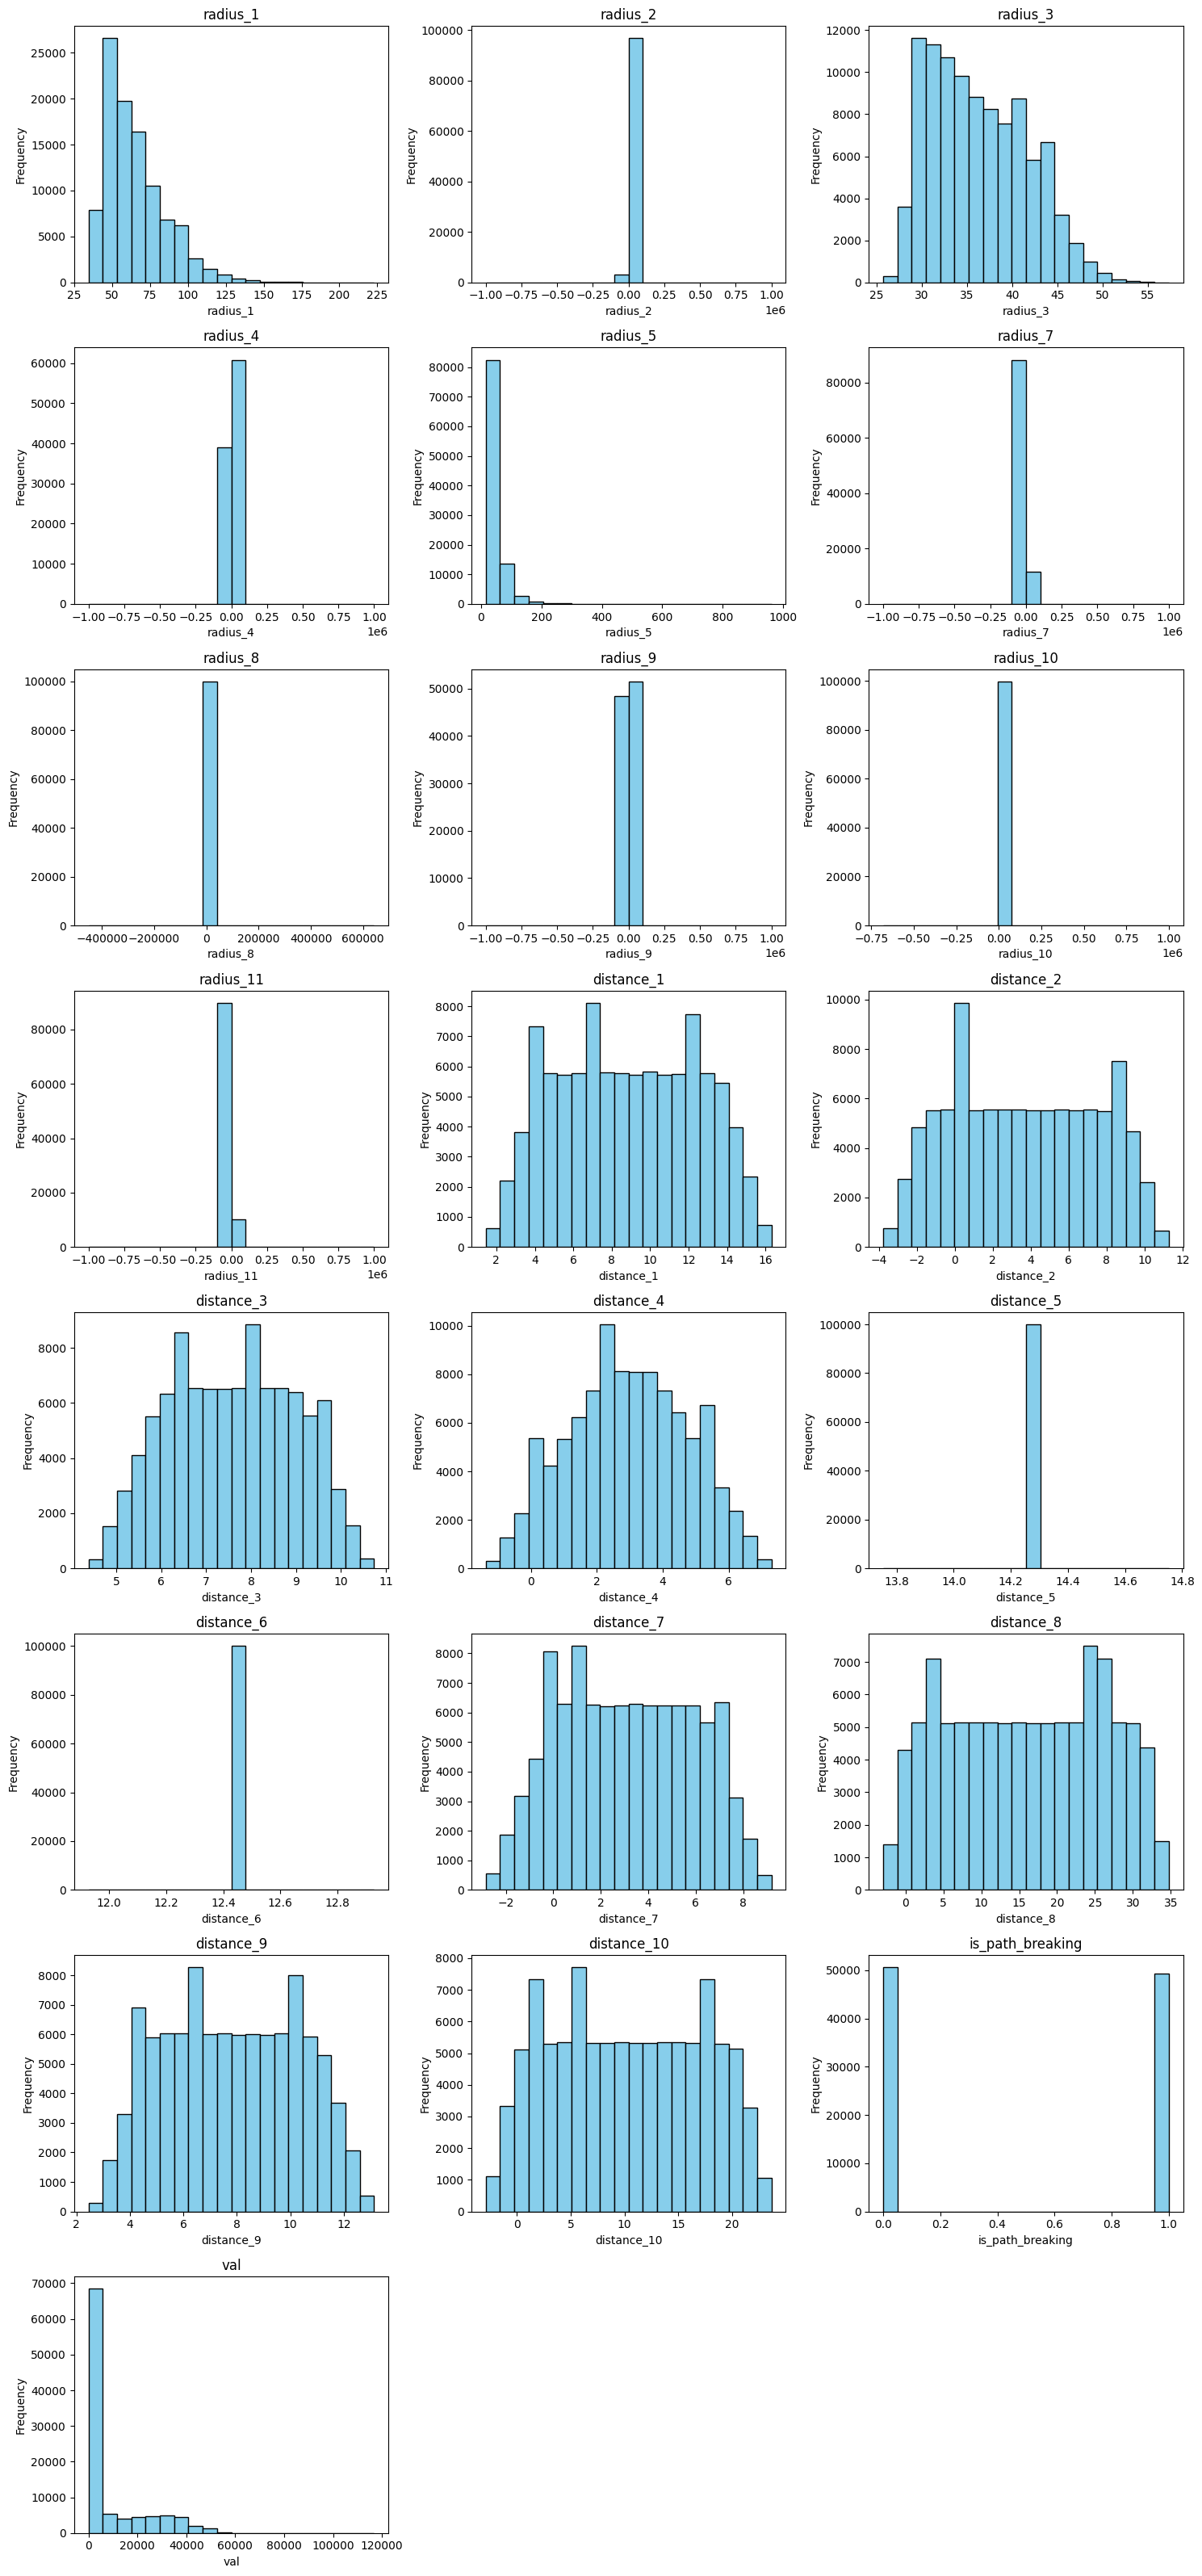

In [7]:
n_cols = len(Numerical_cols)

# Define number of columns in the grid
n_grid_cols = 3  
n_grid_rows = math.ceil(n_cols / n_grid_cols)

# Create subplots
fig, axes = plt.subplots(n_grid_rows, n_grid_cols, figsize=(5 * n_grid_cols, 4 * n_grid_rows))
axes = axes.flatten()  # flatten in case of multiple rows

# Plot histograms
for i, col in enumerate(Numerical_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.savefig("Graphs/Numerical_features.png")
plt.show()

In [11]:
def correlation_matrix(dataset, Title, Save=False):
    
    Numerical_cols_corr_mat = [col for col in dataset.columns if is_numeric_dtype(dataset[col])]
    
    corr_matrix = df_corr_mat[Numerical_cols_corr_mat].corr() # does all of the correlation calculations for you .iloc for rows
    
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(corr_matrix, cmap='Reds')  # matplot lib function red = higher correlation
    fig.colorbar(cax) 
    
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=90)
    ax.set_yticklabels(corr_matrix.columns)
    
    plt.title(Title)
    if Save==True:
        plt.savefig(f"Graphs/{Title}.png")
    plt.show()


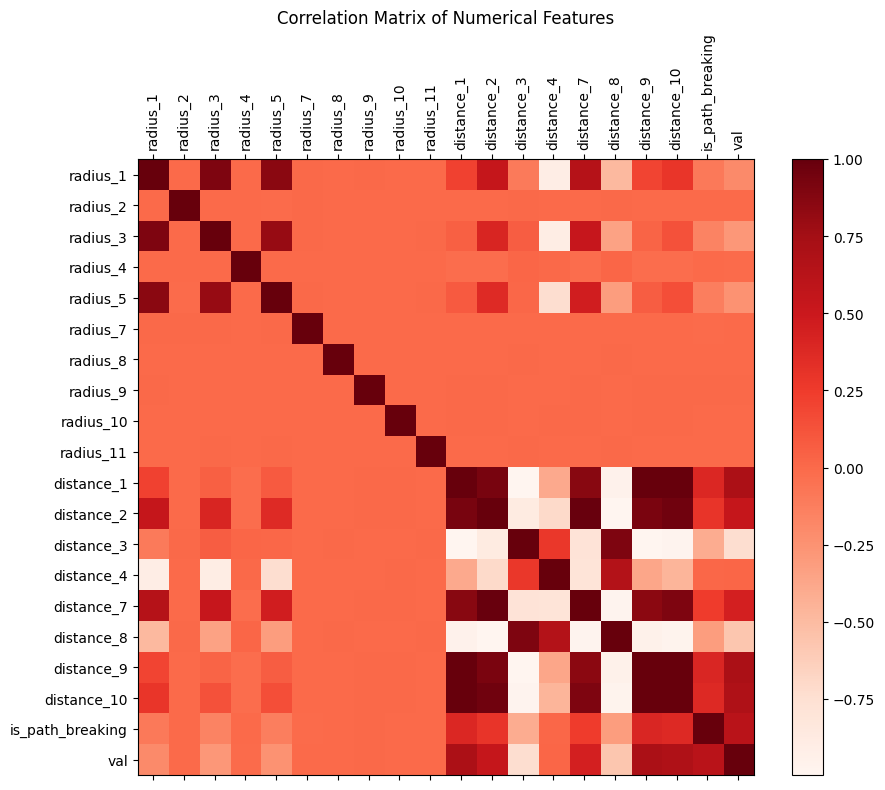

In [13]:
# These two clearly uncorrelated
df_corr_mat = df.drop(columns=["distance_5", "distance_6"])
df_corr_mat_path_mask = df_corr_mat['is_path_breaking'] == 1
df_corr_mat_path = df_corr_mat[~df_corr_mat_path_mask].copy()

correlation_matrix(df_corr_mat,"Correlation Matrix of Numerical Features", Save=False)
# Removing the path breaking values makes no difference

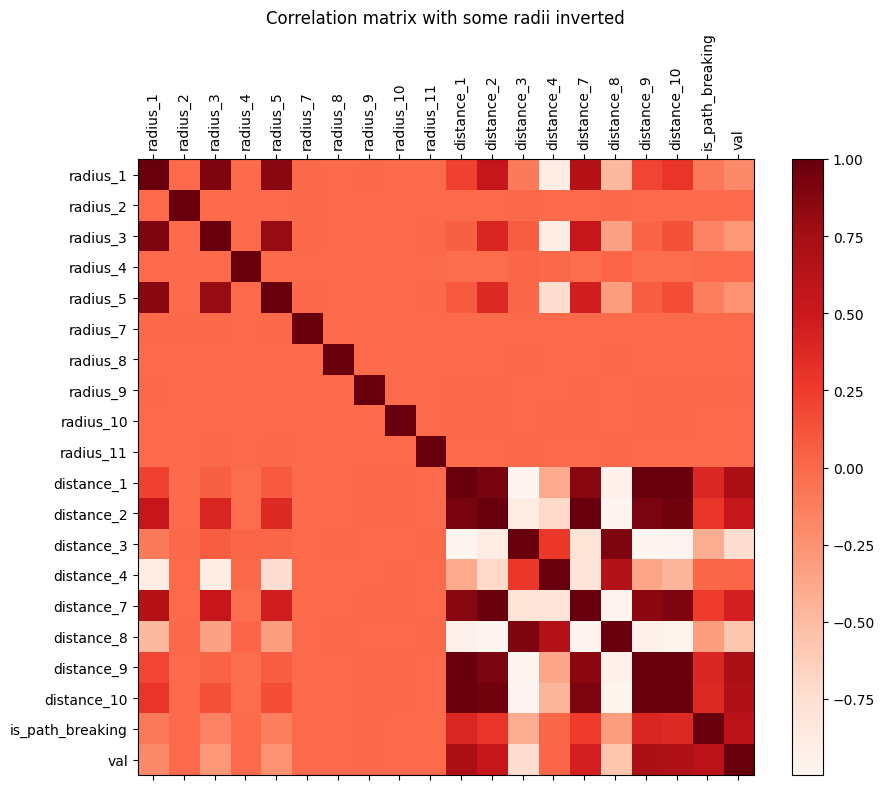

In [14]:
# Checking if inverted radii features with large values made a difference 
cols_to_invert = [
    'radius_2', 'radius_4', 'radius_5', 'radius_7',
    'radius_8', 'radius_9', 'radius_10', 'radius_11'
]

# Make a copy so original df is unchanged
df_corr_mat_inverted = df_corr_mat.copy()

# Invert the values (multiply by -1)
df_corr_mat_inverted[cols_to_invert] = 1/df_corr_mat_inverted[cols_to_invert]

correlation_matrix(df_corr_mat_inverted,"Correlation matrix with some radii inverted")

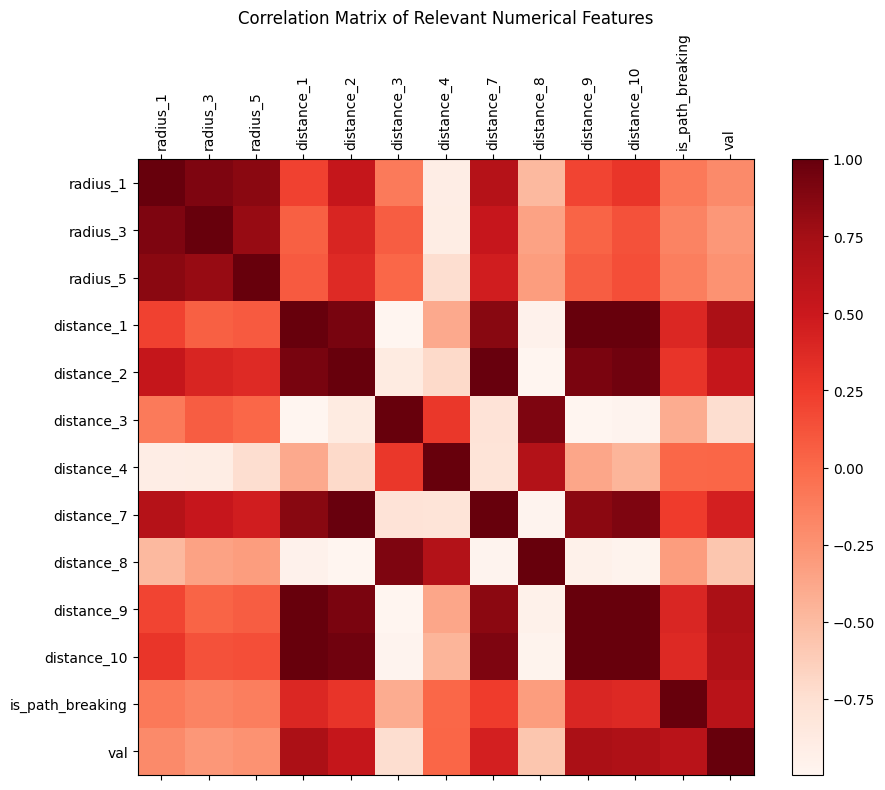

In [10]:
# removed all of the unrelated columns buth still has path breaking
uncorrelated_columns = ['radius_2','radius_4', 'radius_7','radius_8','radius_9','radius_10','radius_11','distance_5','distance_6']
df_pruned = df.drop(columns= uncorrelated_columns)


data_cols_pruned = ['radius_1', 'radius_3', 'radius_5', 'distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_7', 'distance_8', 'distance_9', 'distance_10']

correlation_matrix(df_pruned,"Correlation Matrix of Relevant Numerical Features", Save=True)

radius_1: Number of outliers with z_thresh=3 = 1085
Z-score threshold: ±3
Data bounds for 'radius_1': lower = 5.22, upper = 124.87


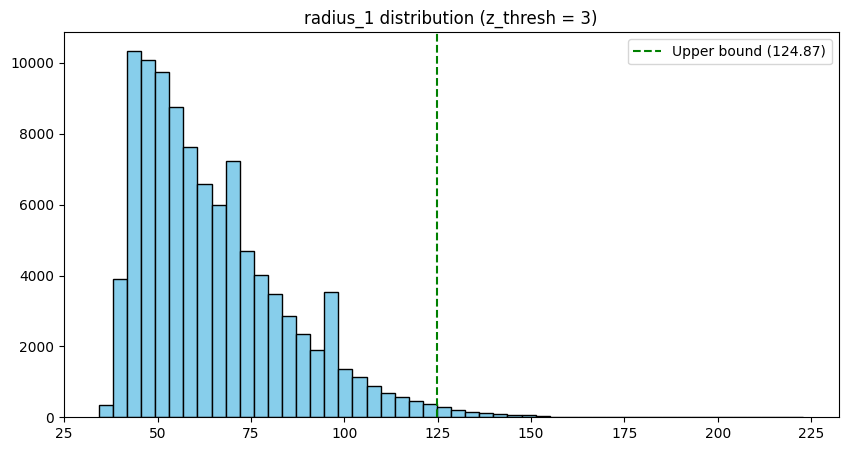

radius_2: Number of outliers with z_thresh=3 = 196
Z-score threshold: ±3
Data bounds for 'radius_2': lower = -39753.26, upper = 40212.59


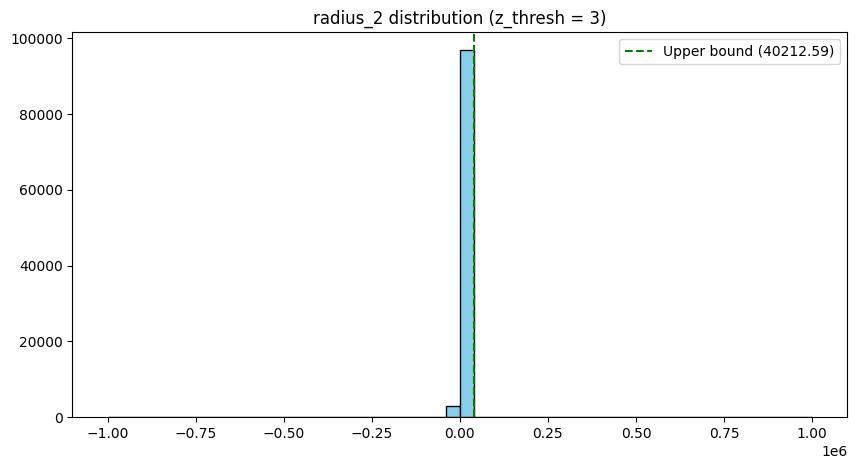

radius_3: Number of outliers with z_thresh=3 = 102
Z-score threshold: ±3
Data bounds for 'radius_3': lower = 20.44, upper = 52.22


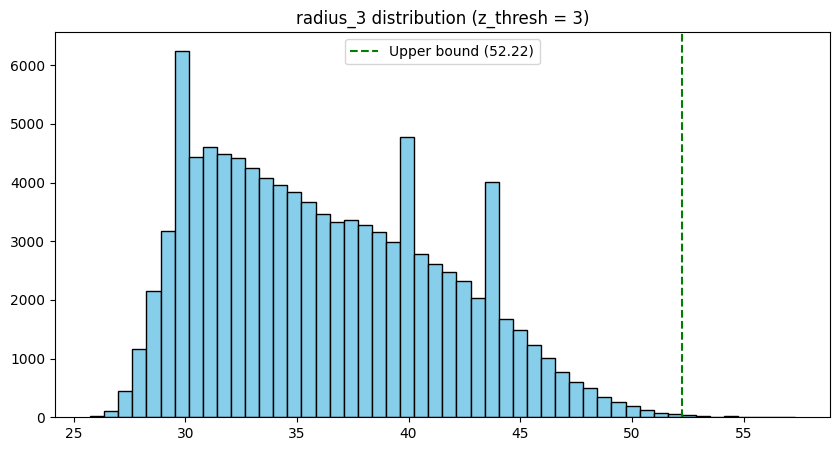

radius_4: Number of outliers with z_thresh=3 = 246
Z-score threshold: ±3
Data bounds for 'radius_4': lower = -48826.00, upper = 49264.78


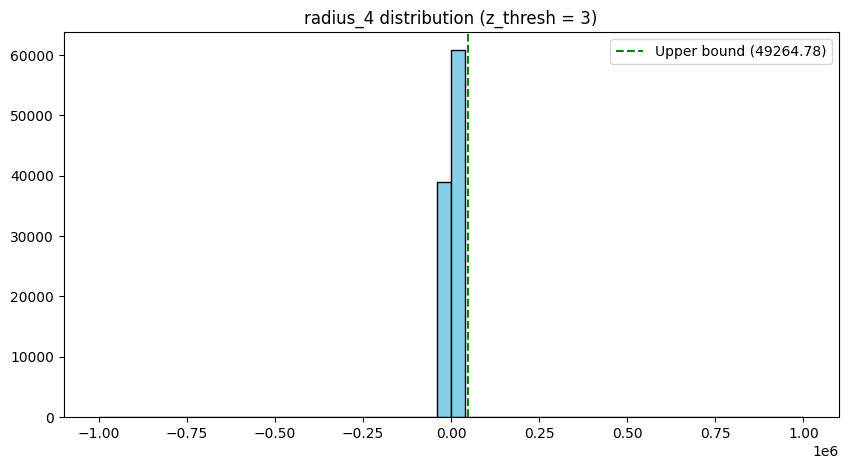

radius_5: Number of outliers with z_thresh=3 = 1887
Z-score threshold: ±3
Data bounds for 'radius_5': lower = -57.39, upper = 143.46


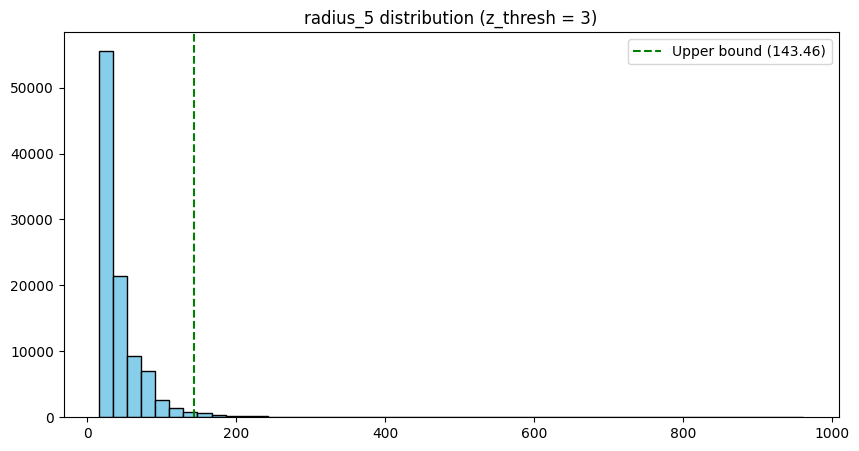

radius_7: Number of outliers with z_thresh=3 = 121
Z-score threshold: ±3
Data bounds for 'radius_7': lower = -28019.98, upper = 27912.79


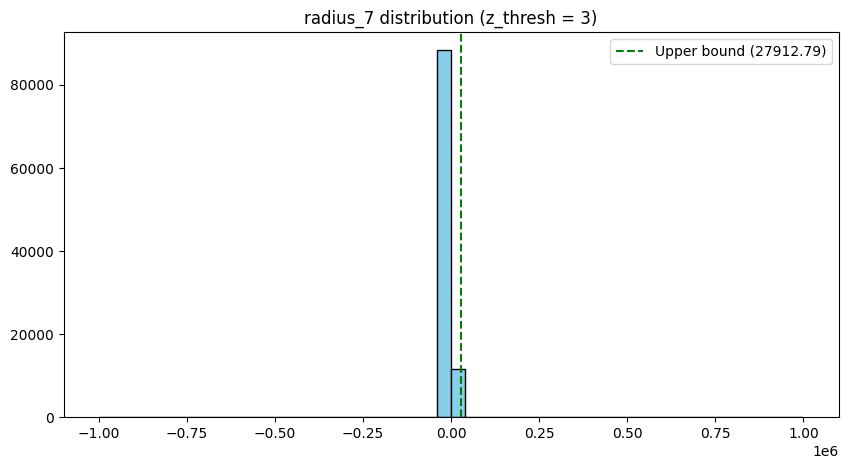

radius_8: Number of outliers with z_thresh=3 = 90
Z-score threshold: ±3
Data bounds for 'radius_8': lower = -10699.12, upper = 10694.92


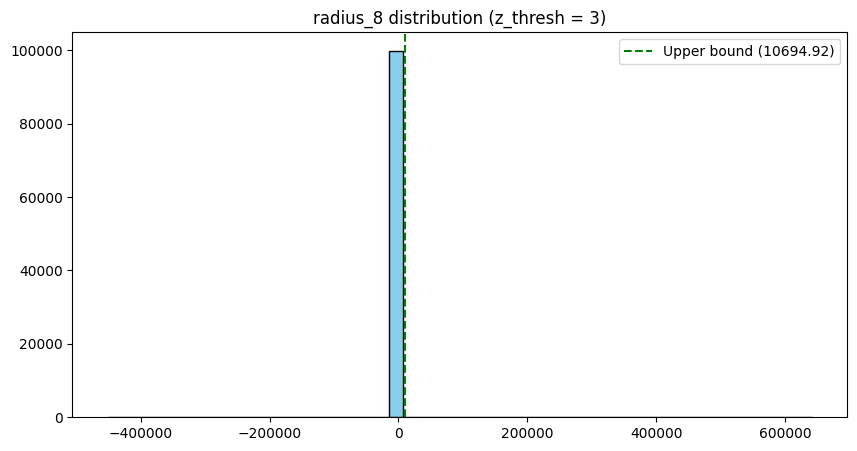

radius_9: Number of outliers with z_thresh=3 = 113
Z-score threshold: ±3
Data bounds for 'radius_9': lower = -25192.57, upper = 25210.32


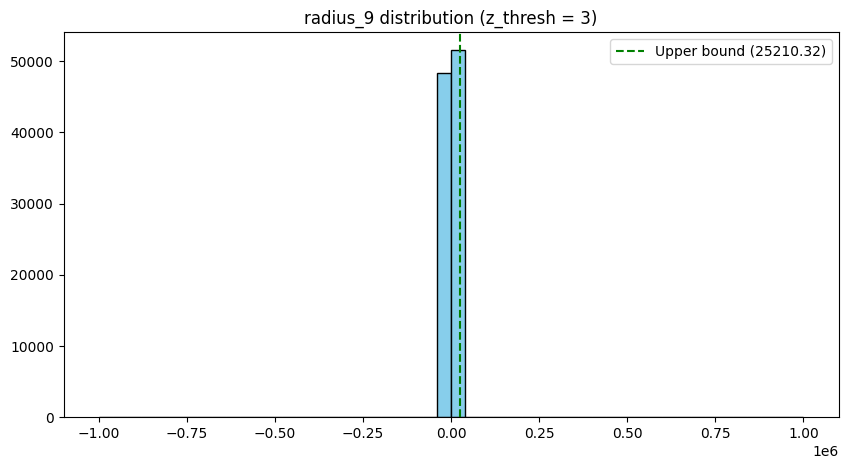

radius_10: Number of outliers with z_thresh=3 = 111
Z-score threshold: ±3
Data bounds for 'radius_10': lower = -17465.01, upper = 17515.79


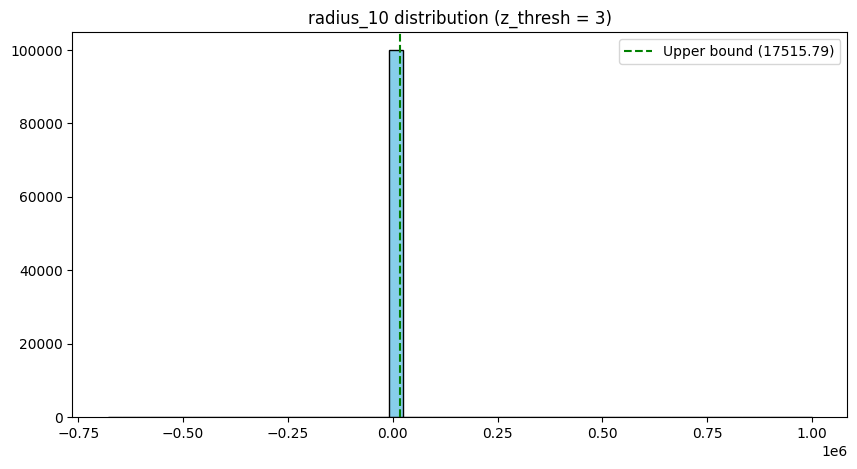

radius_11: Number of outliers with z_thresh=3 = 185
Z-score threshold: ±3
Data bounds for 'radius_11': lower = -29965.96, upper = 29670.41


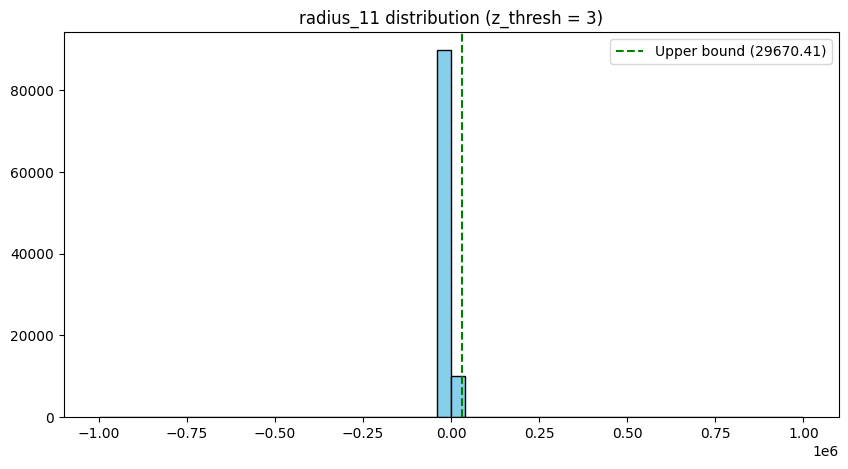

distance_1: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_1': lower = -1.86, upper = 19.51


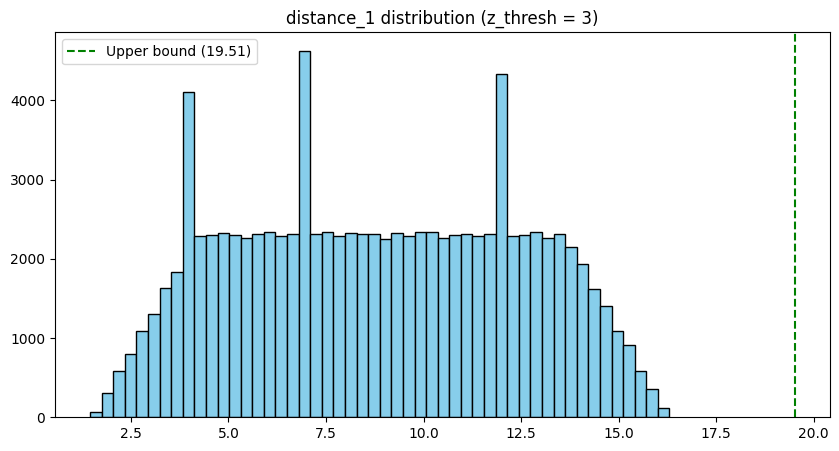

distance_2: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_2': lower = -7.58, upper = 14.90


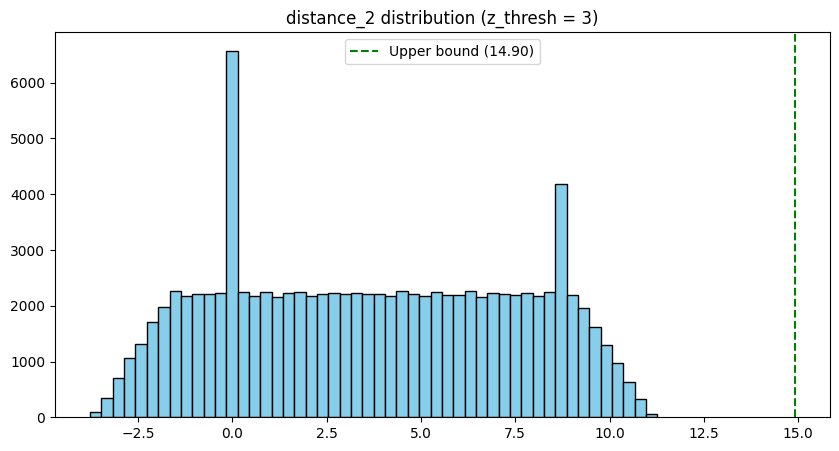

distance_3: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_3': lower = 3.42, upper = 11.78


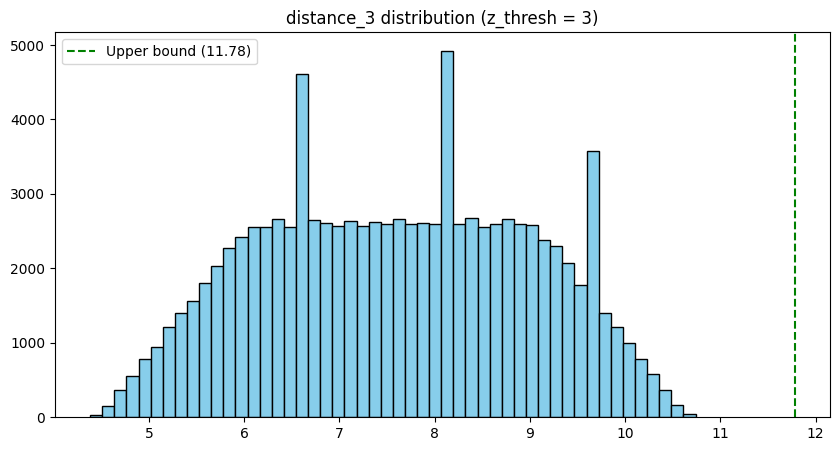

distance_4: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_4': lower = -2.42, upper = 8.36


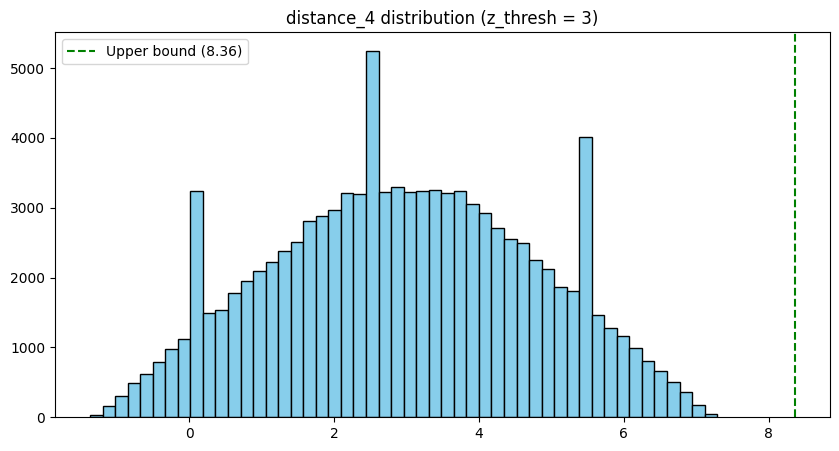

C:\Users\ciara\AppData\Local\Temp\ipykernel_26008\1833975983.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = stats.zscore(data, nan_policy='omit')


distance_5: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_5': lower = 14.25, upper = 14.25


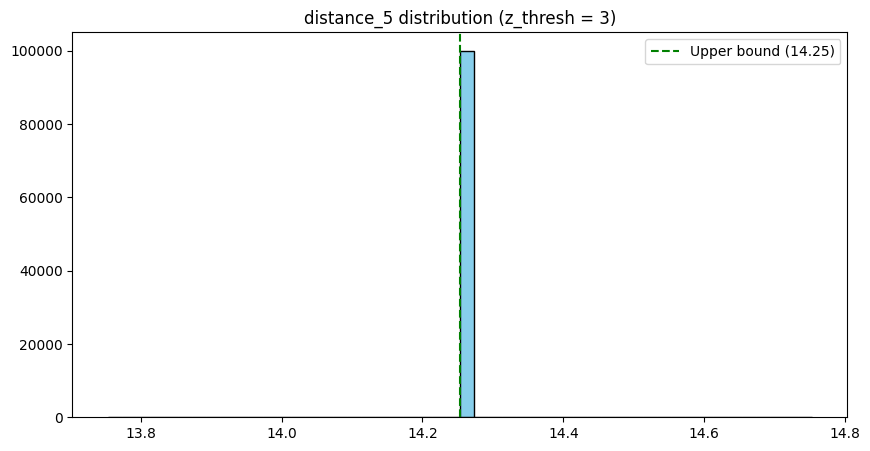

C:\Users\ciara\AppData\Local\Temp\ipykernel_26008\1833975983.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = stats.zscore(data, nan_policy='omit')


distance_6: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_6': lower = 12.43, upper = 12.43


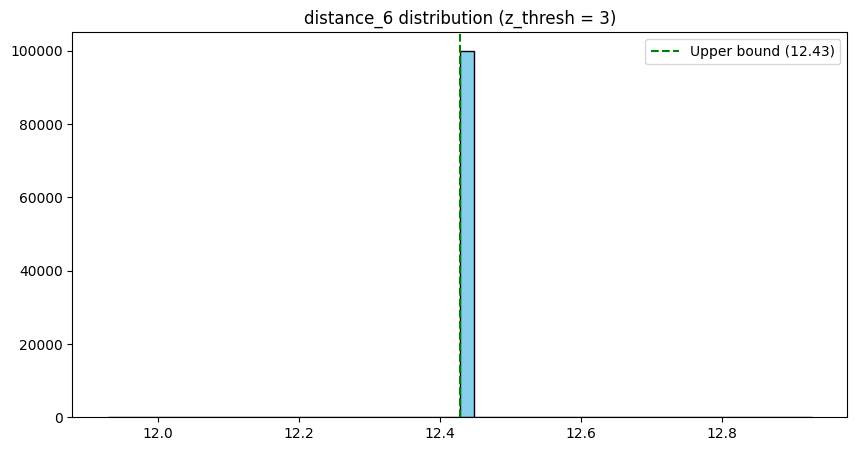

distance_7: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_7': lower = -5.16, upper = 11.40


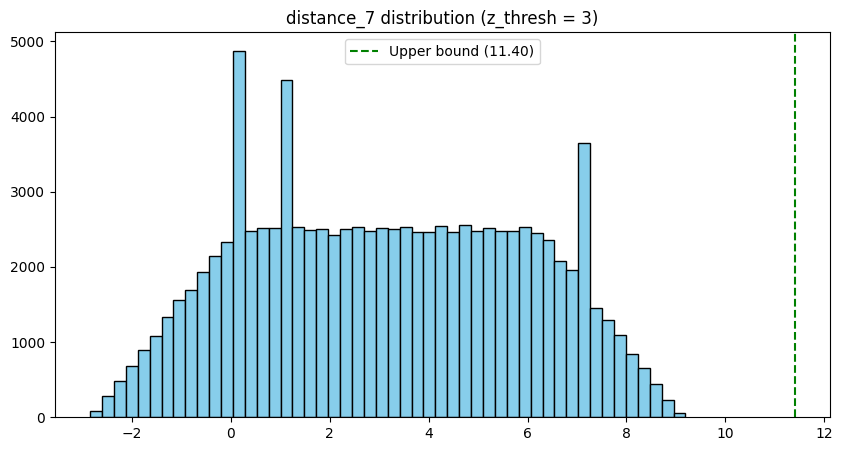

distance_8: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_8': lower = -13.98, upper = 46.16


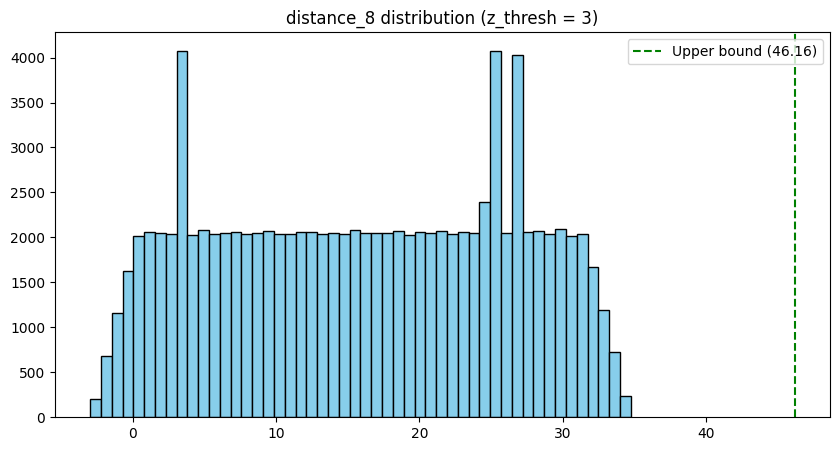

distance_9: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_9': lower = 0.38, upper = 15.22


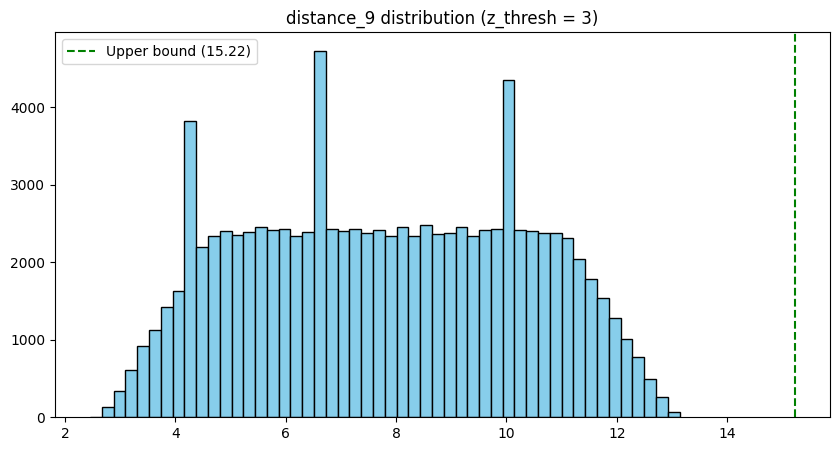

distance_10: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'distance_10': lower = -10.16, upper = 30.58


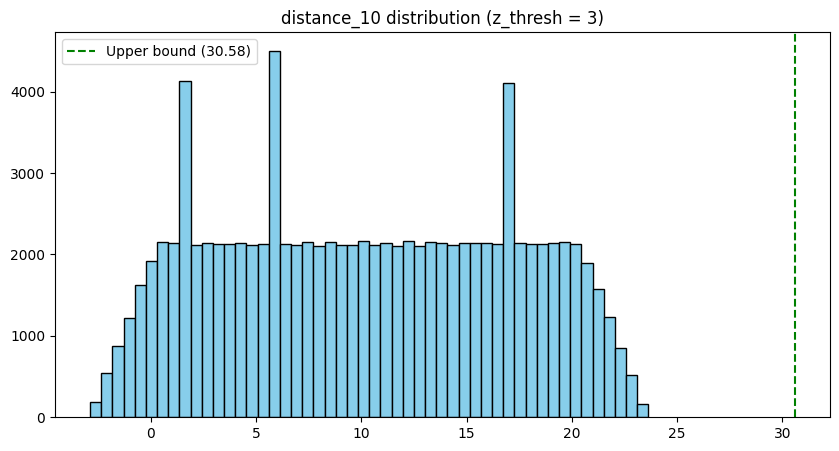

is_path_breaking: Number of outliers with z_thresh=3 = 0
Z-score threshold: ±3
Data bounds for 'is_path_breaking': lower = -1.01, upper = 1.99


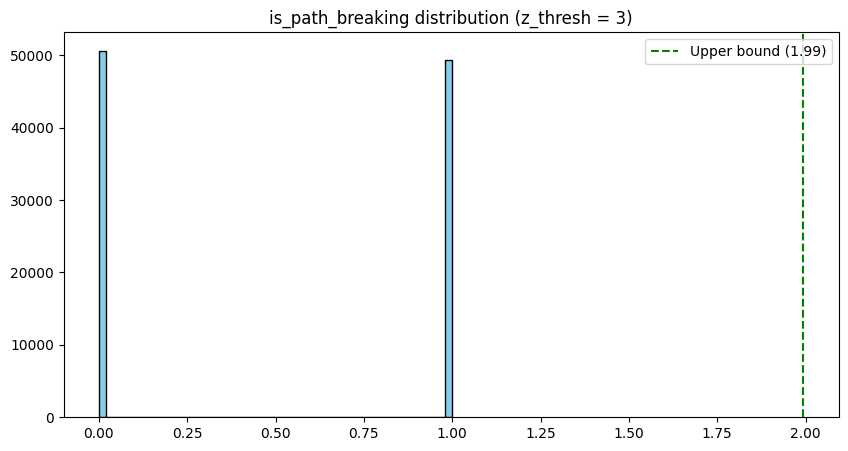

val: Number of outliers with z_thresh=3 = 871
Z-score threshold: ±3
Data bounds for 'val': lower = -31767.61, upper = 49116.34


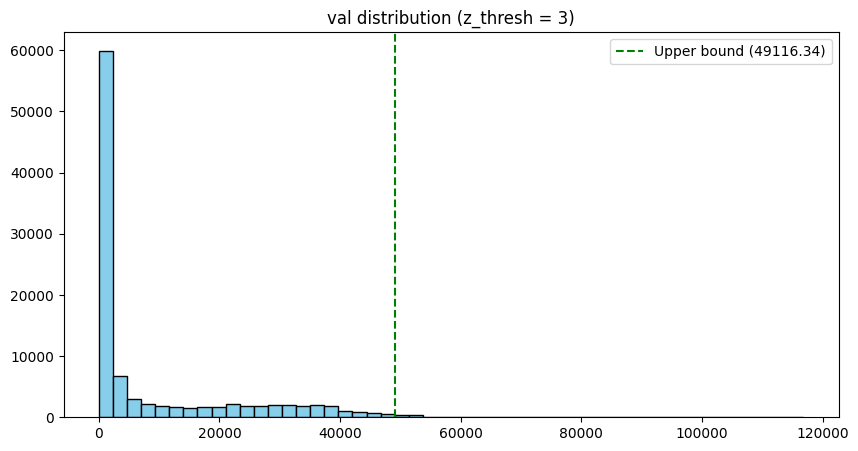

Total rows identified as outliers (any feature): 4208
Data size before removing outliers: 100000
Data size after removing outliers: 95792


In [11]:
z_thresh = 3
all_outliers_mask = np.zeros(len(df), dtype=bool)  # boolean mask for any outlier per row

for col in df.columns:
    data = df[col]
    # Compute z-scores for this feature (ignore NaNs in calculation)
    z_scores = stats.zscore(data, nan_policy='omit')
    outliers = np.abs(z_scores) > z_thresh         # boolean mask of outliers for this feature
    n_outliers = outliers.sum()                    # number of outlier points in this feature
    
    # Print outlier info for this feature
    print(f"{col}: Number of outliers with z_thresh={z_thresh} = {n_outliers}")
    mean_val = data.mean()
    std_val = data.std()
    lower_bound = mean_val - z_thresh * std_val
    upper_bound = mean_val + z_thresh * std_val
    print(f"Z-score threshold: ±{z_thresh}")
    print(f"Data bounds for '{col}': lower = {lower_bound:.2f}, upper = {upper_bound:.2f}")
    
    # Plot the distribution with the upper bound (threshold) marked
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{col} distribution (z_thresh = {z_thresh})")
    # Mark the threshold line (upper bound; lower bound can be shown if relevant and positive)
    plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
    # If lower bound is meaningful (e.g., for symmetric distribution), you could plot it:
    # plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
    plt.legend()
    plt.show()
    
    # Accumulate outliers: mark any row that is an outlier in this feature
    all_outliers_mask |= outliers

# Remove all rows that had any outliers in any feature
df_clean = df[~all_outliers_mask].copy()

# Summary of removal
total_outliers = all_outliers_mask.sum()
print(f"Total rows identified as outliers (any feature): {total_outliers}")
print(f"Data size before removing outliers: {df.shape[0]}")
print(f"Data size after removing outliers: {df_clean.shape[0]}")


## Path Breaking Classifiers

In [12]:
# Different scalers 
scaler = StandardScaler() # Returns a scaled column with mean 0 and standard deviation 1. New values are essentiall Z-scores
minmax_scaler = MinMaxScaler() # Scales x-x_min / x_max - x_min , range [0,1]
robust_scaler = RobustScaler() # scales as x-median / IQR
scaler = MaxAbsScaler() # x / max(|x|)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


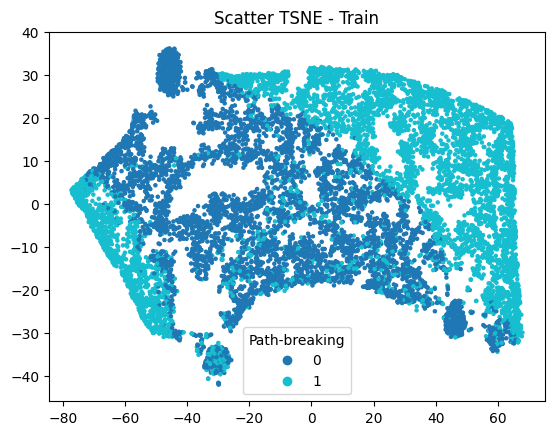

In [13]:
# Function to do it all in one

def tSNEBIN(data, perplex, legend, amount=10000):
    
    idx = np.random.choice(100000, size=amount, replace=False)

    subset = data.iloc[idx]

    X_pruned = subset[data_cols_pruned]
    y_pruned = subset[target_cols]
    
    
    X_pruned = scaler.fit_transform(X_pruned) # use .fit_trainsform, changes it from a pandas array

    
    tsne = TSNE(n_components=2, perplexity=perplex, max_iter=1000)
    Data_tsne = tsne.fit_transform(X_pruned)
    scatterTSNE = plt.scatter(Data_tsne[:,0], Data_tsne[:,1], c=y_pruned['is_path_breaking'], cmap='tab10', s=5)
    plt.title("Scatter TSNE - Train")
    plt.legend(*scatterTSNE.legend_elements(), title=legend)
    plt.savefig("Graphs/Is-path-breaking_TSNE-Train.png")

    plt.show()

    return Data_tsne, y_pruned['is_path_breaking']

Classdata_TSNE = tSNEBIN(df_pruned, 100, 'Path-breaking', amount=10000)

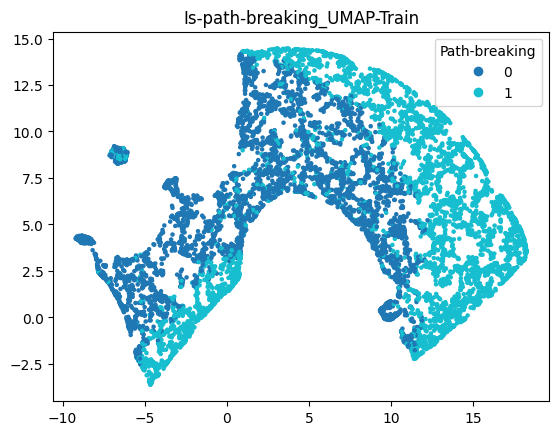

In [14]:
# Function to do it all in one

def UMAPBIN(data, legend, amount=10000):
    
    idx = np.random.choice(100000, size=amount, replace=False)

    subset = data.iloc[idx]

    X_pruned = subset[data_cols_pruned]
    y_pruned = subset[target_cols]
    
    X_pruned = scaler.fit_transform(X_pruned) # use .fit_trainsform, changes it from a pandas array
  
    umap_model = umap.UMAP(n_components=2)
    data_umap = umap_model.fit_transform(X_pruned[:amount])
    scatterUMAP = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=y_pruned['is_path_breaking'][:amount], cmap="tab10", s=5) 
    plt.title("Is-path-breaking_UMAP-Train")
    plt.legend(*scatterUMAP.legend_elements(), title=legend)
    plt.savefig("Graphs/Is-path-breaking_UMAP-Train.png")
    plt.show()

    return data_umap, y_pruned['is_path_breaking'][:amount]

Classdata_umap = UMAPBIN(df_pruned, 'Path-breaking', amount=10000)


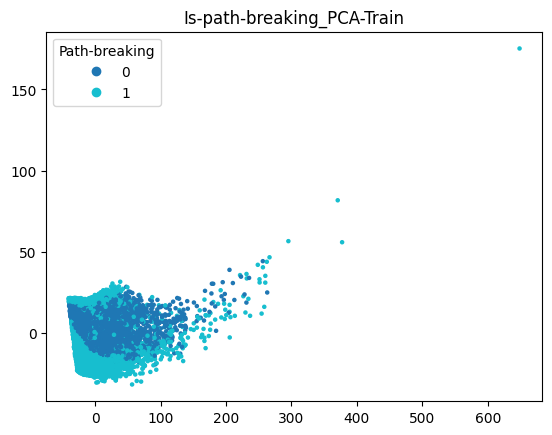

In [15]:

def PCABIN(data, legend, amount=10000):

    idx = np.random.choice(100000, size=amount, replace=False)

    subset = data.iloc[idx]

    X_pruned = subset[data_cols_pruned]
    y_pruned = subset[target_cols]
    
    pca = PCA(n_components=2) # have to define the pca function
    data_pca = pca.fit_transform(X_pruned[:amount]) # use origional data dont what the numbers column
    scatterPCA = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_pruned['is_path_breaking'][:amount], cmap="tab10", s=5) # the c represents the labels so we know what each one is
    plt.title("Is-path-breaking_PCA-Train")
    plt.legend(*scatterPCA.legend_elements(), title=legend)
    plt.savefig("Graphs/Is-path-breaking_PCA-Train.png")
    plt.show()

    return data_pca, y_pruned['is_path_breaking'][:amount]

Classdata_PCA = PCABIN(df_pruned, 'Path-breaking', amount=10000)

In [16]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
def train_plot_decisionboundary_confusionmatrix(classifier,X,y, Title, class_names=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # measure accuracy
    print(f"Train accuracy: {accuracy_score(y_train, classifier.predict(X_train)):.3f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")

    # set color palette
    plt.figure(figsize=(7,6))
    palette = sns.color_palette("RdYlBu", n_colors=len(y.unique()))

    # decision boundary
    DecisionBoundaryDisplay.from_estimator(
        classifier,
        X,
        response_method="predict",
        cmap=plt.cm.RdYlBu,
        alpha=0.3,
    )

    df_plot = pd.DataFrame({
        "PC1": X[:, 0],
        "PC2": X[:, 1],
        "label": y
    })
    
    sns.scatterplot(
            data=df_plot,
            x="PC1",
            y="PC2",
            hue="label",
            palette=palette,
            edgecolor="k"
        )

    plt.legend(title="Path-breaking")
    plt.title(Title)
    plt.savefig(f"Graphs/{Title}.png")
    plt.show()

    #confusion matrix
    plt.figure(figsize=(6, 5))

    cm = confusion_matrix(y_test, y_pred, labels=class_names)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(cmap="Blues", values_format='d')   # Heatmap does NOT overwrite palette
    plt.title(f"{Title}_Confusion-Matrix")
    plt.savefig(f"Graphs/{Title}_cm.png")
    plt.show()

    return classifier
    


In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

Train accuracy: 0.888
Test accuracy: 0.877


<Figure size 700x600 with 0 Axes>

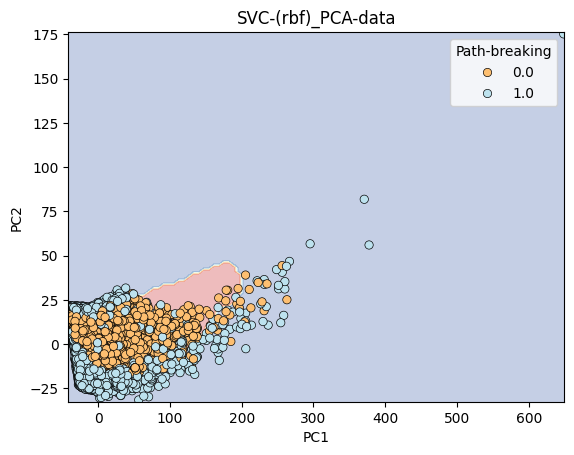

<Figure size 600x500 with 0 Axes>

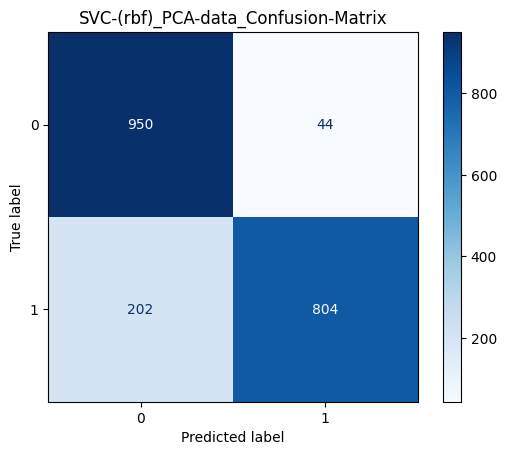

Train accuracy: 0.907
Test accuracy: 0.906


<Figure size 700x600 with 0 Axes>

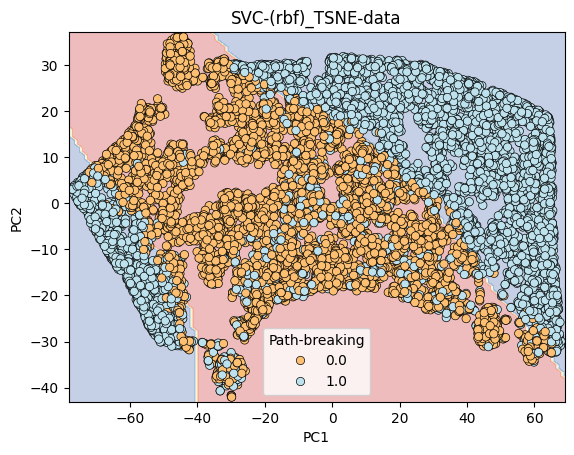

<Figure size 600x500 with 0 Axes>

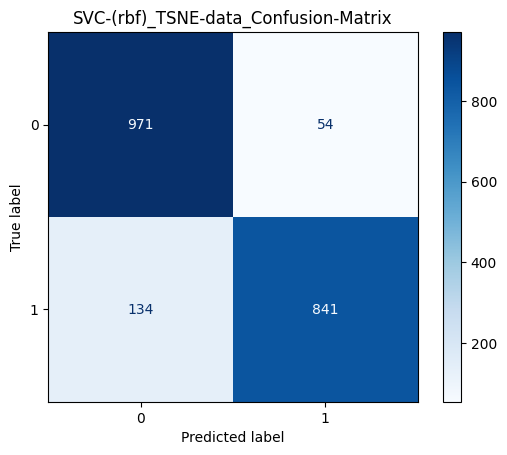

Train accuracy: 0.910
Test accuracy: 0.903


<Figure size 700x600 with 0 Axes>

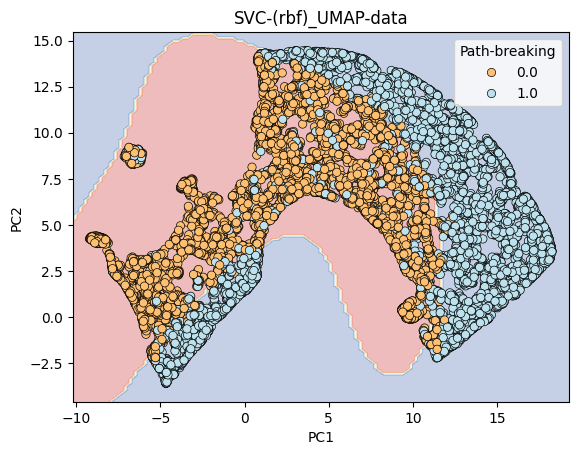

<Figure size 600x500 with 0 Axes>

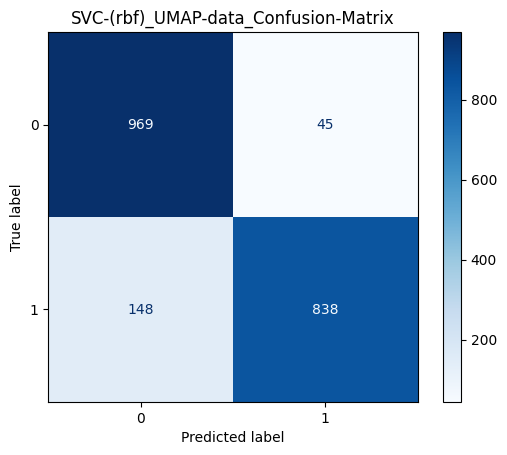

SVC()

In [19]:
svm_clf = SVC(kernel='rbf')

train_plot_decisionboundary_confusionmatrix(svm_clf,Classdata_PCA[0],Classdata_PCA[1],"SVC-(rbf)_PCA-data")
train_plot_decisionboundary_confusionmatrix(svm_clf,Classdata_TSNE[0],Classdata_TSNE[1],"SVC-(rbf)_TSNE-data")
train_plot_decisionboundary_confusionmatrix(svm_clf,Classdata_umap[0],Classdata_umap[1],"SVC-(rbf)_UMAP-data")

Train accuracy: 0.917
Test accuracy: 0.891


<Figure size 700x600 with 0 Axes>

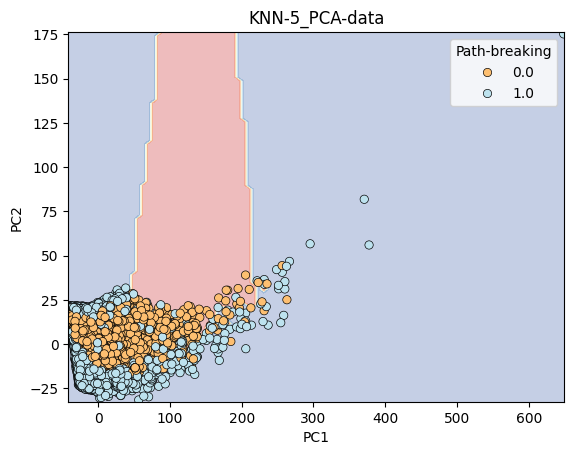

<Figure size 600x500 with 0 Axes>

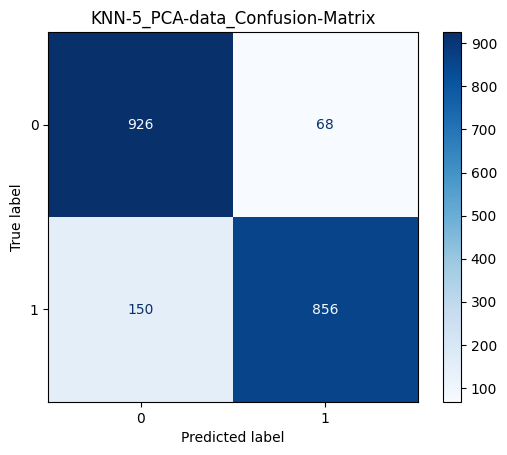

Train accuracy: 0.930
Test accuracy: 0.901


<Figure size 700x600 with 0 Axes>

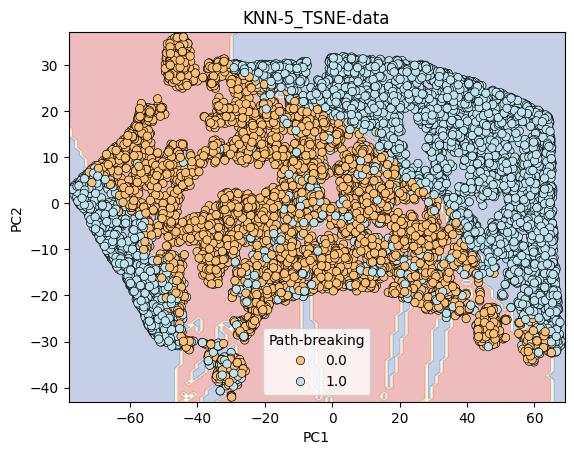

<Figure size 600x500 with 0 Axes>

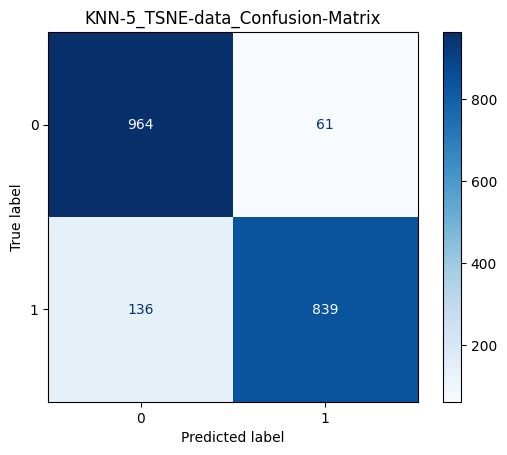

Train accuracy: 0.932
Test accuracy: 0.908


<Figure size 700x600 with 0 Axes>

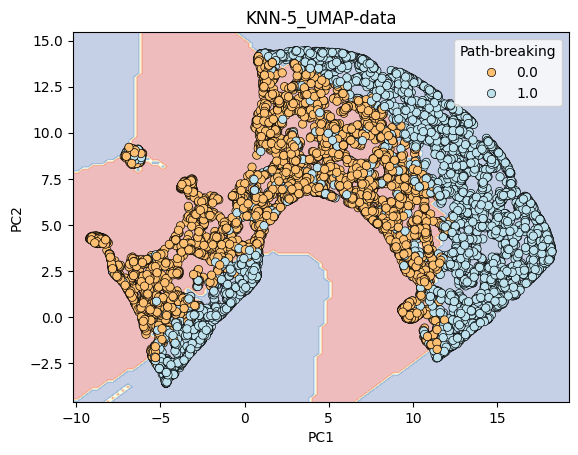

<Figure size 600x500 with 0 Axes>

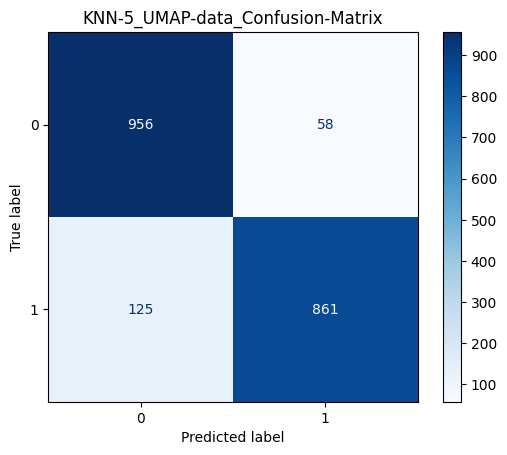

KNeighborsClassifier()

In [20]:
neigh = KNeighborsClassifier(n_neighbors=5)

train_plot_decisionboundary_confusionmatrix(neigh,Classdata_PCA[0],Classdata_PCA[1], "KNN-5_PCA-data")
train_plot_decisionboundary_confusionmatrix(neigh,Classdata_TSNE[0],Classdata_TSNE[1], "KNN-5_TSNE-data")
train_plot_decisionboundary_confusionmatrix(neigh,Classdata_umap[0],Classdata_umap[1], "KNN-5_UMAP-data")

Train accuracy: 0.905
Test accuracy: 0.892


<Figure size 700x600 with 0 Axes>

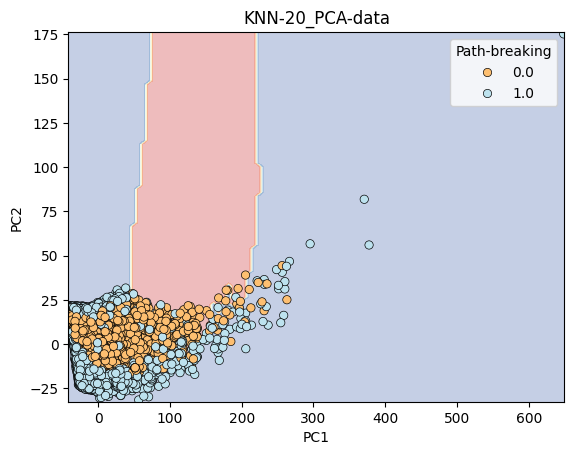

<Figure size 600x500 with 0 Axes>

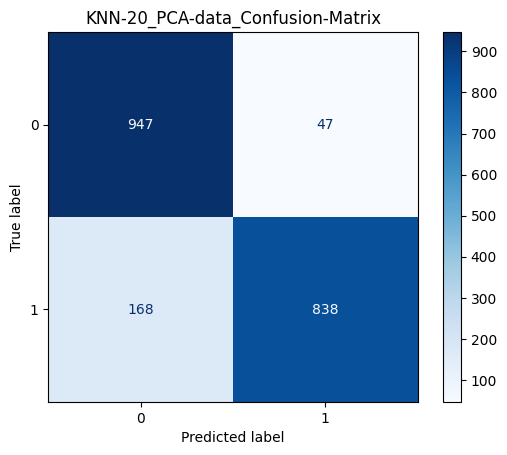

Train accuracy: 0.922
Test accuracy: 0.914


<Figure size 700x600 with 0 Axes>

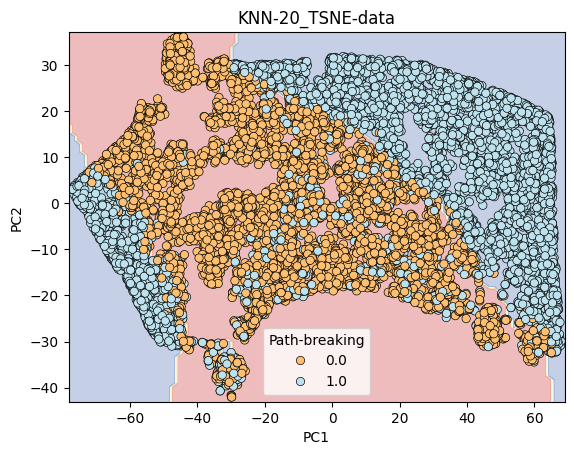

<Figure size 600x500 with 0 Axes>

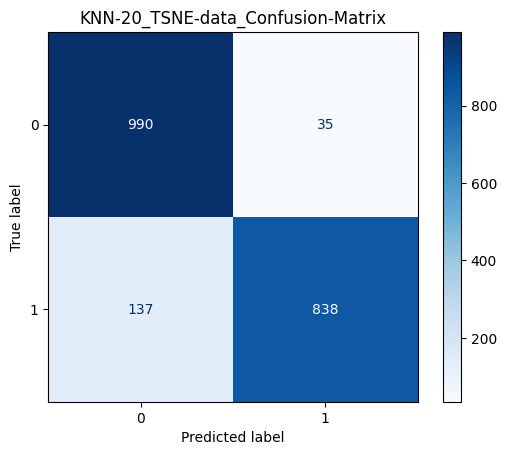

Train accuracy: 0.920
Test accuracy: 0.911


<Figure size 700x600 with 0 Axes>

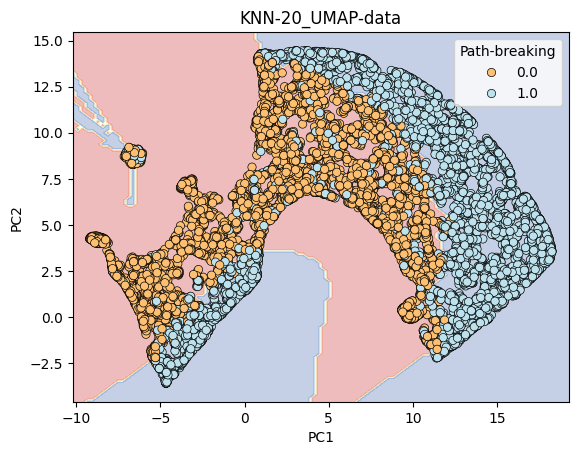

<Figure size 600x500 with 0 Axes>

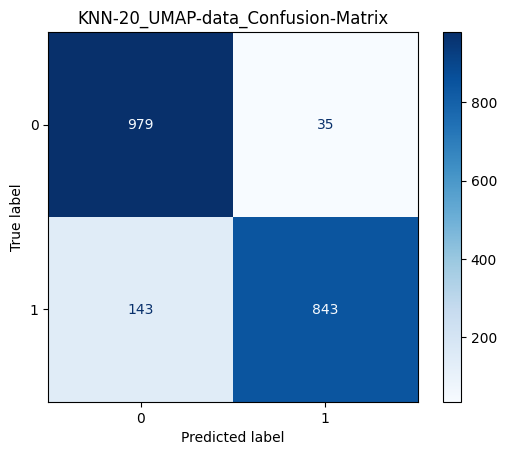

KNeighborsClassifier(n_neighbors=20)

In [21]:
neigh = KNeighborsClassifier(n_neighbors=20)

train_plot_decisionboundary_confusionmatrix(neigh,Classdata_PCA[0],Classdata_PCA[1], "KNN-20_PCA-data")
train_plot_decisionboundary_confusionmatrix(neigh,Classdata_TSNE[0],Classdata_TSNE[1], "KNN-20_TSNE-data")
train_plot_decisionboundary_confusionmatrix(neigh,Classdata_umap[0],Classdata_umap[1], "KNN-20_UMAP-data")

Train accuracy: 0.716
Test accuracy: 0.725


<Figure size 700x600 with 0 Axes>

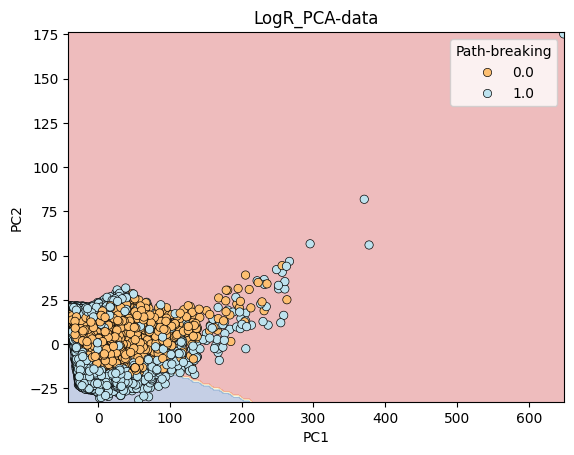

<Figure size 600x500 with 0 Axes>

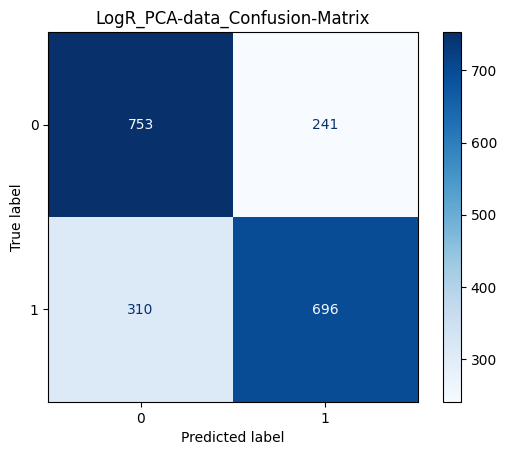

Train accuracy: 0.714
Test accuracy: 0.718


<Figure size 700x600 with 0 Axes>

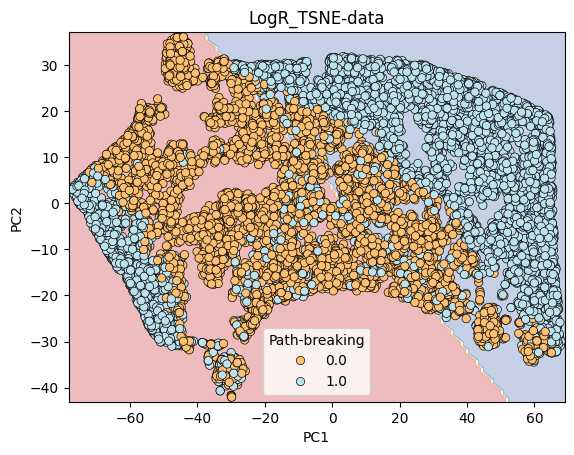

<Figure size 600x500 with 0 Axes>

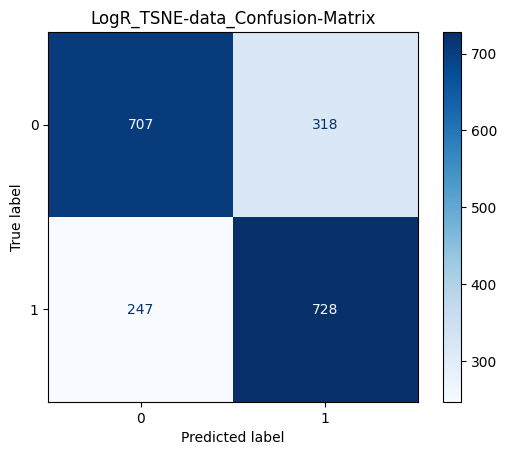

Train accuracy: 0.679
Test accuracy: 0.667


<Figure size 700x600 with 0 Axes>

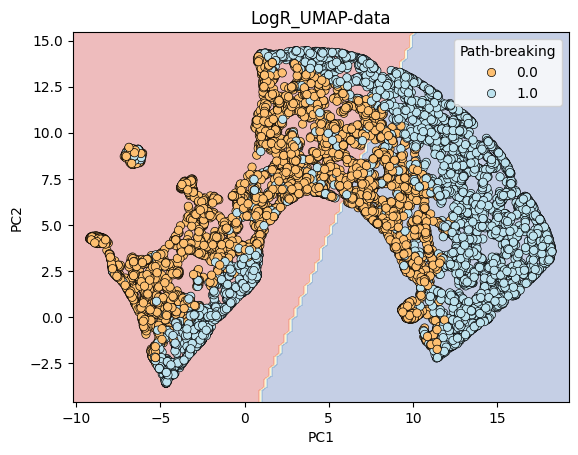

<Figure size 600x500 with 0 Axes>

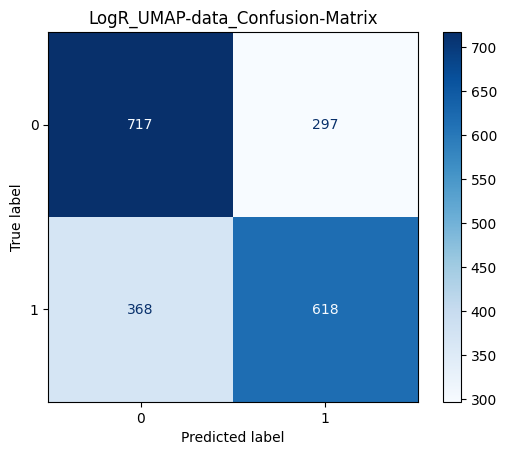

LogisticRegression(C=100000.0)

In [22]:
clf = LogisticRegression(C=1e5)

train_plot_decisionboundary_confusionmatrix(clf,Classdata_PCA[0],Classdata_PCA[1], "LogR_PCA-data")
train_plot_decisionboundary_confusionmatrix(clf,Classdata_TSNE[0],Classdata_TSNE[1], "LogR_TSNE-data")
train_plot_decisionboundary_confusionmatrix(clf,Classdata_umap[0],Classdata_umap[1], "LogR_UMAP-data")

# Val Classifier

In [9]:
# Filterin out all of the path breaking ones
path_breaking_mask = df['is_path_breaking'] == 1
df_path = df[~path_breaking_mask].copy()
uncorrelated_columns = ['radius_2','radius_4', 'radius_7','radius_8','radius_9','radius_10','radius_11','distance_5','distance_6']
df_path_pruned = df_path.drop(columns= uncorrelated_columns)

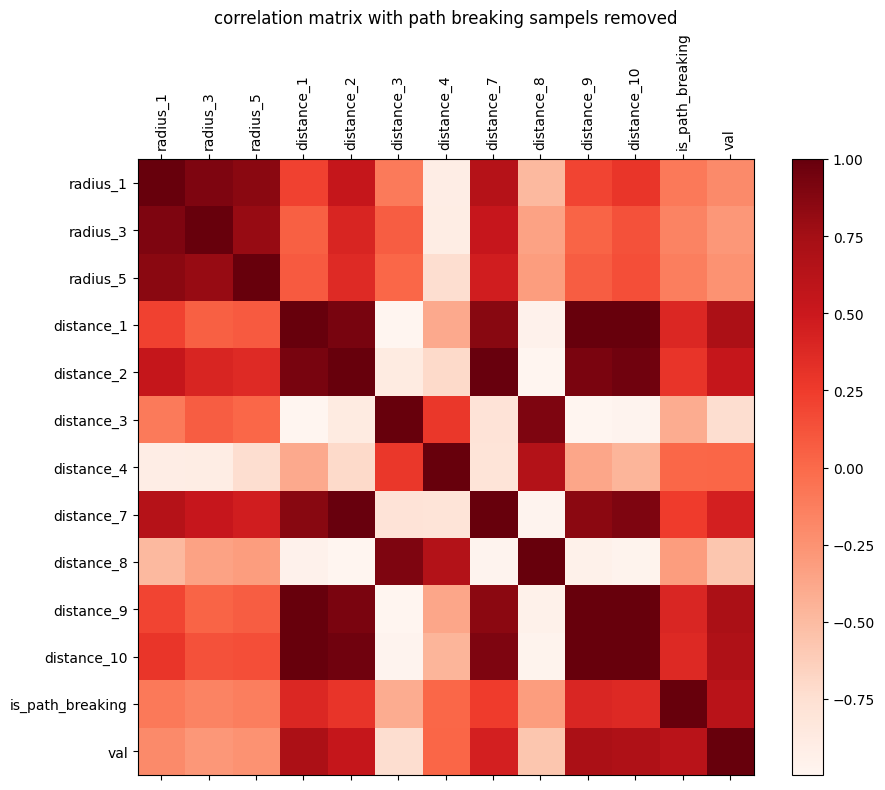

In [15]:
correlation_matrix(df_path_pruned, "correlation matrix with path breaking sampels removed")

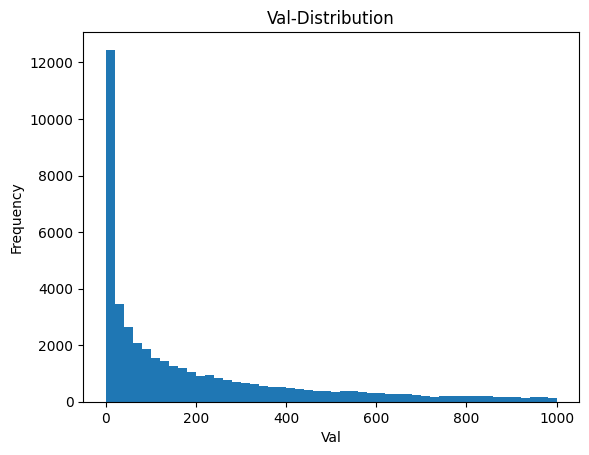

In [27]:
df_path_pruned['val'].describe()
plt.hist(df_path_pruned['val'], bins=50, range=(0,1000))
plt.title('Val-Distribution')
plt.xlabel('Val')
plt.ylabel('Frequency')
plt.savefig('Graphs/Val-Distribution-Hist.png')

In [28]:
(df_path_pruned['val']<100).sum()/50615

np.float64(0.4444137113503902)

In [29]:
# Function seperated the values in df['val'] into different bins
# Run this before dim_vis if want to classify val
def Val_class(df, max_val, n_bins):
    bin_size = max_val / n_bins
    bins = [i * bin_size for i in range(n_bins)] + [max_val, np.inf]
    labels = list(range(n_bins + 1))

    print("Bin ranges:")
    for i in range(len(labels)):
        left = bins[i]
        right = bins[i+1]
        print(f"  Bin {labels[i]}: [{left:.2f}, {right:.2f})")

    df['val_class'] = pd.cut(df['val'], bins=bins, labels=labels, right=False)

Bin ranges:
  Bin 0: [0.00, 10.00)
  Bin 1: [10.00, 20.00)
  Bin 2: [20.00, 30.00)
  Bin 3: [30.00, 40.00)
  Bin 4: [40.00, 50.00)
  Bin 5: [50.00, 60.00)
  Bin 6: [60.00, 70.00)
  Bin 7: [70.00, 80.00)
  Bin 8: [80.00, 90.00)
  Bin 9: [90.00, 100.00)
  Bin 10: [100.00, inf)


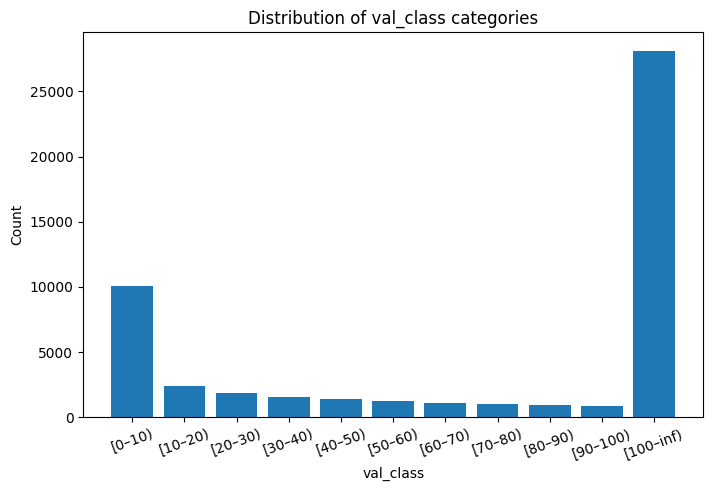

In [30]:
Val_class(df_path_pruned, 100, 10)

counts = df_path_pruned['val_class'].value_counts().sort_index()

bin_labels = [f"[{i*10}–{(i+1)*10})" for i in range(10)]
bin_labels.append("[100–inf)")   # last bin

# Plot
plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(int), counts.values)
plt.xlabel("val_class")
plt.ylabel("Count")
plt.title("Distribution of val_class categories")
plt.xticks(ticks=range(11), labels=bin_labels, rotation=20)   # ensure ticks show 0–10
plt.savefig("Graphs/Dis_val_class.png")
plt.show()

In [33]:
# Defining new column names
data_cols_path_pruned = [c for c in df_path_pruned.columns if c not in ("is_path_breaking", "val")]
target_cols = ['is_path_breaking', 'val', 'val_class']

Bin ranges:
  Bin 0: [0.00, 10.00)
  Bin 1: [10.00, 20.00)
  Bin 2: [20.00, 30.00)
  Bin 3: [30.00, 40.00)
  Bin 4: [40.00, 50.00)
  Bin 5: [50.00, 60.00)
  Bin 6: [60.00, 70.00)
  Bin 7: [70.00, 80.00)
  Bin 8: [80.00, 90.00)
  Bin 9: [90.00, 100.00)
  Bin 10: [100.00, inf)


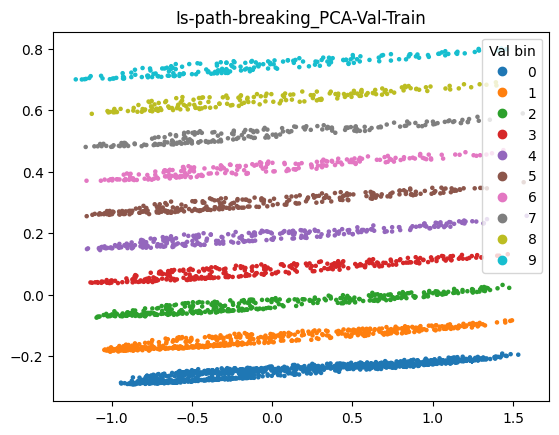

In [34]:

def PCABIN(data, legend, maxval=100, bins=10, amount=10000, top_removed=True):
    
    Val_class(data, maxval, bins)
    
    if top_removed:

        idx = np.random.choice(50615, size=amount, replace=False)

        subset = data.iloc[idx]
     
        Val_mask = subset['val_class'] == bins
        df_path_pruned_reduced = subset[~Val_mask].copy()
    
        X_path_pruned = df_path_pruned_reduced[data_cols_path_pruned]
        y_path_pruned = df_path_pruned_reduced[target_cols]
    
    
        X_train_pruned = scaler.fit_transform(X_path_pruned) # use .fit_trainsform, changes it from a pandas array

        
    else:

        idx = np.random.choice(50615, size=amount, replace=False)

        subset = data.iloc[idx]
      
        X_path_pruned = subset[data_cols_path_pruned]
        y_path_pruned = subset[target_cols]
    
    
        X_train_pruned = scaler.fit_transform(X_path_pruned) # use .fit_trainsform, changes it from a pandas array


    pca = PCA(n_components=2, random_state=42) # have to define the pca function
    data_pca = pca.fit_transform(X_train_pruned) # use origional data dont what the numbers column
    scatterPCA = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_path_pruned['val_class'], cmap="tab10", s=5) # the c represents the labels so we know what each one is
    plt.title("Is-path-breaking_PCA-Val-Train")
    plt.legend(*scatterPCA.legend_elements(), title=legend)
    plt.savefig("Graphs/PCA-Val-Train.png")
    plt.show()


    return data_pca, y_path_pruned['val_class']

Classdata_PCA = PCABIN(df_path_pruned, 'Val bin', maxval=100, bins=10, amount=10000, top_removed=True)

Train accuracy: 1.000
Test accuracy: 0.997


C:\Users\ciara\AppData\Local\Temp\ipykernel_26008\4103381607.py:31: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Figure size 700x600 with 0 Axes>

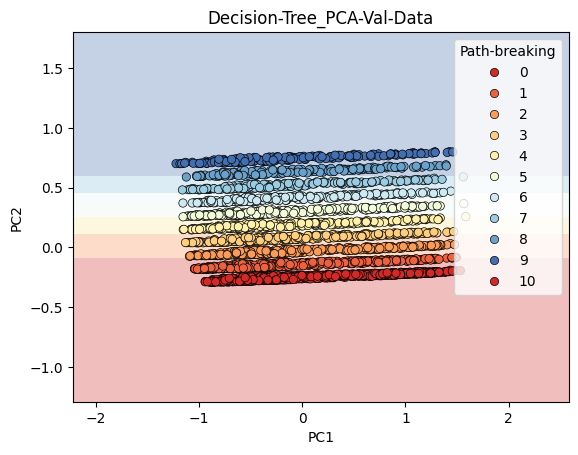

<Figure size 600x500 with 0 Axes>

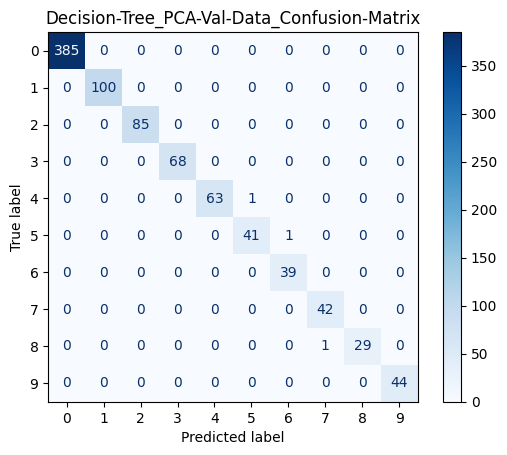

DecisionTreeClassifier(max_depth=10)

In [36]:
clf = DecisionTreeClassifier(max_depth=10)

train_plot_decisionboundary_confusionmatrix(clf,Classdata_PCA[0],Classdata_PCA[1],"Decision-Tree_PCA-Val-Data")

# Decision Tree Classifiers

## Loading data and preprocessing

In [16]:
dataset = load_dataset("csv", data_files="dataset-iml-task.csv")
df = dataset["train"].to_pandas() 

In [17]:
df = df.drop(columns=["radius_6"])

In [18]:
categorical_cols = [col for col in df.columns if isinstance(df[col].dtype, pd.CategoricalDtype)]  #isinstance(obj, cls) checks whether obj is an instance of class cls
Numerical_cols = [col for col in df.columns if is_numeric_dtype(df[col])]

In [19]:
# labelling different columns
target_cols = ['is_path_breaking','val']
data_cols = ['radius_1','radius_2','radius_3','radius_4','radius_5','radius_7','radius_8','radius_9','radius_10','radius_11','distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_7','distance_8','distance_9','distance_10']
radius_cols = ['radius_1','radius_2','radius_3','radius_4','radius_5','radius_7','radius_8','radius_9','radius_10','radius_11']
distance_cols = ['distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_7','distance_8','distance_9','distance_10']
radius_cols = ['radius_1','radius_2','radius_3','radius_4','radius_5','radius_7','radius_8','radius_9','radius_10','radius_11']

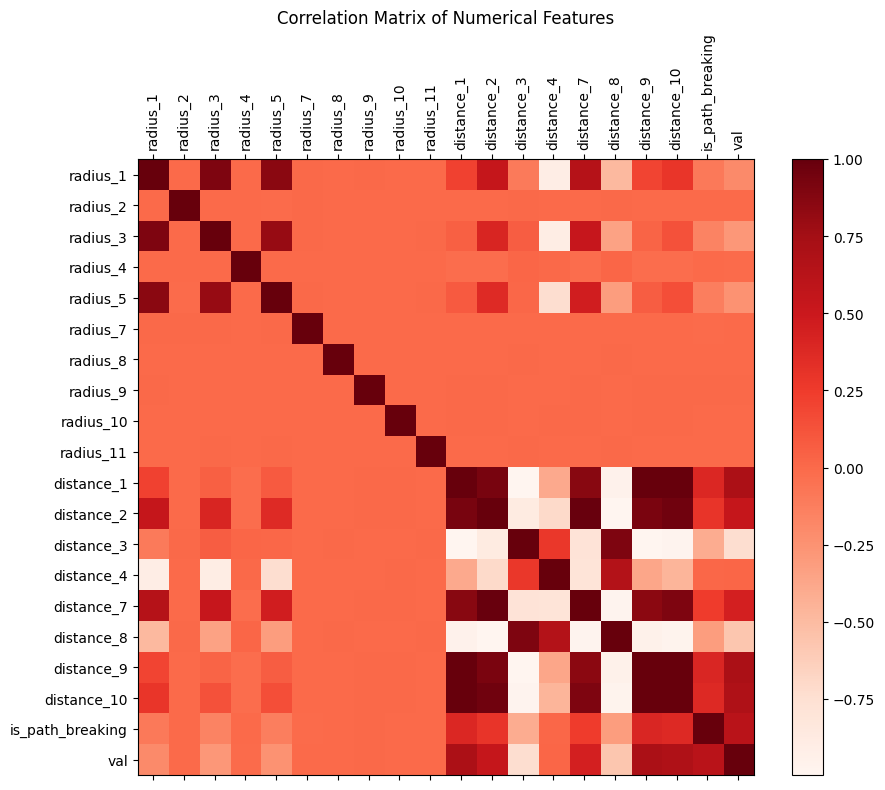

In [20]:
df_corr_mat = df.drop(columns=["distance_5", "distance_6"])
Numerical_cols_corr_mat = [col for col in df_corr_mat.columns if is_numeric_dtype(df_corr_mat[col])]

corr_matrix = df_corr_mat[Numerical_cols_corr_mat].corr() # does all of the correlation calculations for you .iloc for rows

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='Reds')  # matplot lib function red = higher correlation
fig.colorbar(cax) 

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [21]:
# Different scalers 
scaler = StandardScaler() # Returns a scaled column with mean 0 and standard deviation 1. New values are essentiall Z-scores
minmax_scaler = MinMaxScaler() # Scales x-x_min / x_max - x_min , range [0,1]
robust_scaler = RobustScaler() # scales as x-median / IQR
scaler = MaxAbsScaler() # x / max(|x|)

In [22]:
df_s = scaler.fit_transform(df)
df_s.shape
df_s = pd.DataFrame(data=df_s, columns=df.columns)
df_s.describe()
# not all mean zero due to the presence of outliers

radius_1       radius_2       radius_3       radius_4  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.291799       0.000230       0.634173       0.000219   
std         0.089466       0.013328       0.092480       0.016348   
min         0.153748      -1.000000       0.449323      -1.000000   
25%         0.221994       0.000161       0.555009      -0.000196   
50%         0.270363       0.000231       0.622309       0.000106   
75%         0.338709       0.000375       0.701167       0.000257   
max         1.000000       1.000000       1.000000       1.000000   

            radius_5       radius_7       radius_8       radius_9  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.044778      -0.000054      -0.000003       0.000009   
std         0.034833       0.009322       0.005553       0.008400   
min         0.016290      -1.000000      -0.702911      -1.000000   
25%         0.023103      -0.000095      -0.000033      -0.000052   
50%         0.032632      -0.000047      -0.000017       0.000023   
75%         0.054165      -0.000031       0.000037       0.000048   
max         1.000000       1.000000       1.000000       1.000000   

           radius_10      radius_11     distance_1     distance_2  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.000025      -0.000148       0.541421       0.325107   
std         0.005830       0.009939       0.218450       0.332451   
min        -0.680054      -1.000000       0.088992      -0.334266   
25%        -0.000032      -0.000173       0.358332       0.014383   
50%         0.000019      -0.000101       0.537000       0.315908   
75%         0.000048      -0.000064       0.734847       0.617634   
max         1.000000       1.000000       1.000000       1.000000   

          distance_3     distance_4  distance_5  distance_6     distance_7  \
count  100000.000000  100000.000000    100000.0    100000.0  100000.000000   
mean        0.707427       0.407078         1.0         1.0       0.339298   
std         0.129804       0.246529         0.0         0.0       0.300316   
min         0.407846      -0.187854         1.0         1.0      -0.309627   
25%         0.605287       0.227495         1.0         1.0       0.089468   
50%         0.709634       0.401834         1.0         1.0       0.330796   
75%         0.812690       0.592438         1.0         1.0       0.592684   
max         1.000000       1.000000         1.0         1.0       1.000000   

          distance_8     distance_9    distance_10  is_path_breaking  \
count  100000.000000  100000.000000  100000.000000     100000.000000   
mean        0.463212       0.593747       0.431969          0.493850   
std         0.288534       0.188359       0.287264          0.499965   
min        -0.085192       0.186702      -0.122318          0.000000   
25%         0.206509       0.436592       0.187357          0.000000   
50%         0.470859       0.590085       0.425794          0.000000   
75%         0.717931       0.759227       0.688838          1.000000   
max         1.000000       1.000000       1.000000          1.000000   

                val  
count  1.000000e+05  
mean   7.425987e-02  
std    1.154058e-01  
min    8.165843e-10  
25%    8.658865e-04  
50%    7.360985e-03  
75%    1.146467e-01  
max    1.000000e+00

Number of outliers with z_thresh=3: 871
Z-score threshold: ±3
Corresponding data bounds: lower = -31767.61, upper = 49116.34


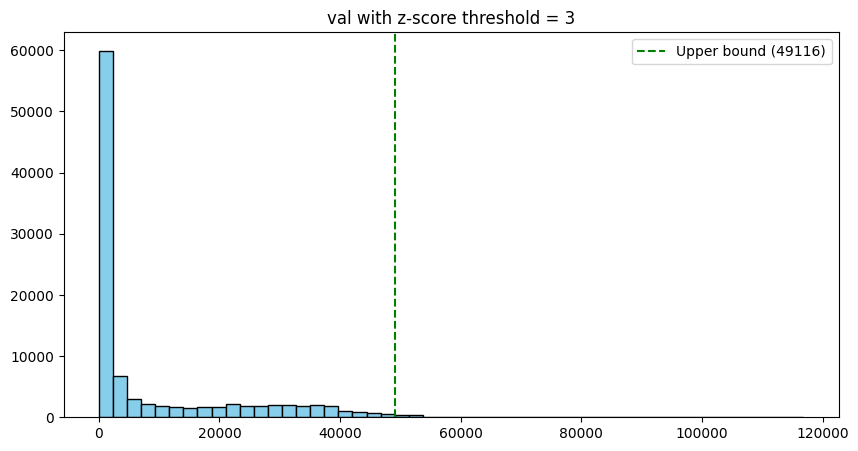

Data size before removing outliers: 100000
Data size after removing outliers: 99129


In [23]:
# Outlier finding and removal
z_thresh = 3 
col = 'val'
data = df[col]

z_scores = stats.zscore(data, nan_policy='omit') # Computes the z scores of the data using the mean and standed deviation, omits the unknown values


outliers = np.abs(z_scores) > z_thresh # boolean array for all the rows saying whether or not they are an outlier
n_outliers = outliers.sum()
print(f"Number of outliers with z_thresh={z_thresh}: {n_outliers}")

mean_val = data.mean()
std_val = data.std()

lower_bound = mean_val - z_thresh * std_val
upper_bound = mean_val + z_thresh * std_val

print(f"Z-score threshold: ±{z_thresh}")
print(f"Corresponding data bounds: lower = {lower_bound:.2f}, upper = {upper_bound:.2f}")
#lowerbound in this case is negative which makes no sense

plt.figure(figsize=(10,5))
plt.hist(data, bins=50, color='skyblue', edgecolor='black')
plt.title(f'{col} with z-score threshold = {z_thresh}')

#plotting vertical lines for lower and upper, dont need lower in this case
#plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound ({lower_bound:.0f})')
plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper bound ({upper_bound:.0f})')
plt.legend()
plt.show()

# Remove outliers from dataframe
df_clean = df[~outliers].copy() # ~ is the not operation, flips the boolean array
print(f"Data size before removing outliers: {df.shape[0]}")
print(f"Data size after removing outliers: {df_clean.shape[0]}")



In [24]:
df_clean_s = scaler.fit_transform(df_clean)
df_clean_s.shape
df_clean_s = pd.DataFrame(data=df_clean_s, columns=df.columns)
df_clean_s.describe()
# not all mean zero due to the presence of outliers

radius_1      radius_2      radius_3      radius_4      radius_5  \
count  99129.000000  99129.000000  99129.000000  99129.000000  99129.000000   
mean       0.292324      0.000230      0.634934      0.000216      0.044985   
std        0.089669      0.013386      0.092497      0.016413      0.034915   
min        0.153748     -1.000000      0.449323     -1.000000      0.016290   
25%        0.222055      0.000161      0.555948     -0.000198      0.023264   
50%        0.271282      0.000232      0.623597      0.000106      0.032858   
75%        0.339599      0.000377      0.702085      0.000254      0.054168   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           radius_7      radius_8      radius_9     radius_10     radius_11  \
count  99129.000000  99129.000000  99129.000000  99129.000000  99129.000000   
mean      -0.000054     -0.000003      0.000009      0.000026     -0.000151   
std        0.009363      0.005578      0.008437      0.005856      0.009983   
min       -1.000000     -0.702911     -1.000000     -0.680054     -1.000000   
25%       -0.000096     -0.000033     -0.000052     -0.000032     -0.000174   
50%       -0.000047     -0.000017      0.000022      0.000020     -0.000102   
75%       -0.000031      0.000037      0.000048      0.000048     -0.000065   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         distance_1    distance_2    distance_3    distance_4  distance_5  \
count  99129.000000  99129.000000  99129.000000  99129.000000     99129.0   
mean       0.539294      0.321344      0.709676      0.406354         1.0   
std        0.216541      0.331339      0.128049      0.247453         0.0   
min        0.089228     -0.334266      0.408110     -0.187854         1.0   
25%        0.357671      0.011830      0.608242      0.225680         1.0   
50%        0.535125      0.310797      0.711595      0.399262         1.0   
75%        0.731508      0.610120      0.813701      0.594350         1.0   
max        1.000000      1.000000      1.000000      1.000000         1.0   

       distance_6    distance_7    distance_8    distance_9   distance_10  \
count     99129.0  99129.000000  99129.000000  99129.000000  99129.000000   
mean          1.0      0.336623      0.466766      0.593247      0.427968   
std           0.0      0.300175      0.287169      0.186968      0.284751   
min           1.0     -0.309627     -0.085192      0.187523     -0.122436   
25%           1.0      0.087406      0.213080      0.437019      0.185126   
50%           1.0      0.326539      0.475088      0.589793      0.421710   
75%           1.0      0.586375      0.717947      0.758444      0.682816   
max           1.0      1.000000      1.000000      1.000000      1.000000   

       is_path_breaking           val  
count      99129.000000  9.912900e+04  
mean           0.489443  1.688610e-01  
std            0.499891  2.626927e-01  
min            0.000000  1.942216e-09  
25%            0.000000  2.021816e-03  
50%            0.000000  1.680387e-02  
75%            1.000000  2.542363e-01  
max            1.000000  1.000000e+00

# Training Models

# Bagging (Random Forest)

In [25]:
# Splitting the data into test and train

X = df[data_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train) # use .fit_trainsform, changes it from a pandas array
X_test = scaler.fit_transform(X_test)

In [26]:
X = df_clean[data_cols]
y = df_clean['is_path_breaking']

In [27]:
y = y.astype(int)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


Train the bagging model

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay


Evaluation

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12307
           1       0.97      0.89      0.93     11641

    accuracy                           0.93     23948
   macro avg       0.94      0.93      0.93     23948
weighted avg       0.94      0.93      0.93     23948

[[11952   355]
 [ 1235 10406]]


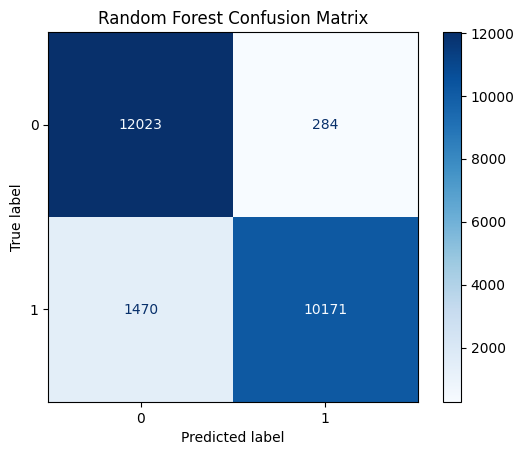

In [39]:
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=[0, 1],
    cmap="Blues",
    values_format="d"
)

plt.title("Random Forest Confusion Matrix")
plt.show()


Feature importances

In [29]:
importances = rf.feature_importances_
feature_names = list(X.columns)

for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(name, round(imp, 4))


radius_10 0.1271
distance_3 0.1245
radius_8 0.123
distance_9 0.0874
distance_1 0.0813
distance_10 0.0772
distance_8 0.061
radius_11 0.0407
distance_2 0.0375
radius_5 0.0344
radius_9 0.0323
radius_4 0.03
distance_4 0.0272
radius_7 0.0261
radius_3 0.0245
radius_2 0.0231
distance_7 0.0225
radius_1 0.0201
distance_5 0.0
distance_6 0.0


# Boosting (Gradient Boosting)

Train the boosting model

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=2,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))


              precision    recall  f1-score   support

           0       0.89      0.98      0.93     12307
           1       0.97      0.87      0.92     11641

    accuracy                           0.93     23948
   macro avg       0.93      0.93      0.93     23948
weighted avg       0.93      0.93      0.93     23948

[[12023   284]
 [ 1470 10171]]


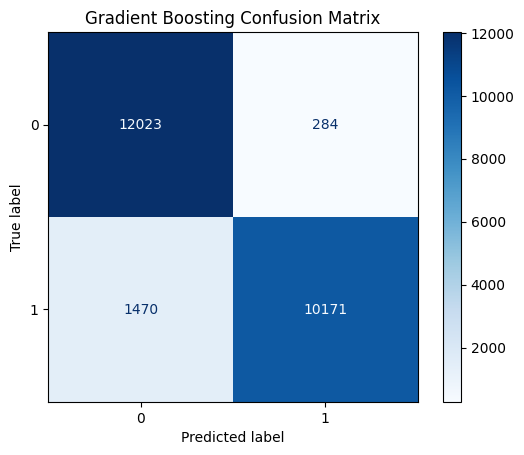

In [38]:
y_pred = gb.predict(X_test)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[0, 1],
    cmap="Blues",
    values_format="d"
)
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


Feature importances

In [31]:
importances_gb = gb.feature_importances_

for name, score in sorted(zip(X.columns, importances_gb), key=lambda x: x[1], reverse=True):
    print(name, round(score,4))


distance_3 0.3408
radius_10 0.2741
radius_8 0.1668
distance_8 0.1321
distance_10 0.0479
radius_4 0.0115
radius_7 0.0086
radius_2 0.0039
distance_9 0.0032
radius_5 0.0032
radius_9 0.0024
radius_11 0.0023
distance_1 0.0014
distance_4 0.0009
radius_3 0.0003
distance_2 0.0003
distance_7 0.0003
radius_1 0.0001
distance_5 0.0
distance_6 0.0


# Boosting (AdaBoost)

Train the boosting model

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=300,
    learning_rate=0.1,
    random_state=42
)

ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

print(classification_report(y_test, y_pred_ada))
print(confusion_matrix(y_test, y_pred_ada))


              precision    recall  f1-score   support

           0       0.88      0.98      0.92     12307
           1       0.97      0.86      0.91     11641

    accuracy                           0.92     23948
   macro avg       0.92      0.92      0.92     23948
weighted avg       0.92      0.92      0.92     23948

[[12003   304]
 [ 1654  9987]]


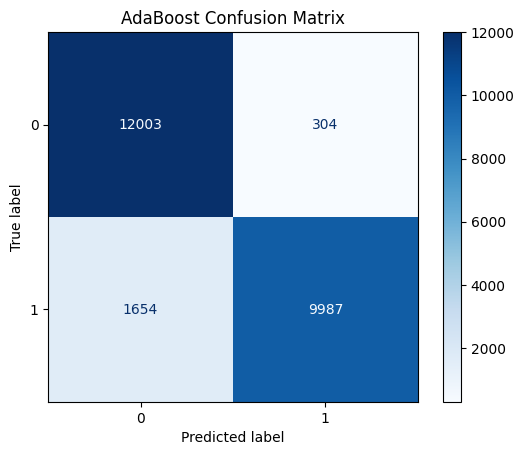

In [40]:
y_pred = ada.predict(X_test)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[0, 1],
    cmap="Blues",
    values_format="d"
)
plt.title("AdaBoost Confusion Matrix")
plt.show()


Feature importances

In [33]:
importances_ada = ada.feature_importances_

for name, score in sorted(zip(X.columns, importances_ada), key=lambda x: x[1], reverse=True):
    print(name, round(score, 4))


distance_3 0.5259
distance_8 0.1411
radius_10 0.1088
radius_8 0.1043
radius_11 0.0843
distance_10 0.0355
radius_1 0.0
radius_2 0.0
radius_3 0.0
radius_4 0.0
radius_5 0.0
radius_7 0.0
radius_9 0.0
distance_1 0.0
distance_2 0.0
distance_4 0.0
distance_5 0.0
distance_6 0.0
distance_7 0.0
distance_9 0.0


# Boosting (XGBoost)

Train the boosting model

In [34]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12307
           1       0.98      0.89      0.93     11641

    accuracy                           0.93     23948
   macro avg       0.94      0.93      0.93     23948
weighted avg       0.94      0.93      0.93     23948

[[12049   258]
 [ 1321 10320]]


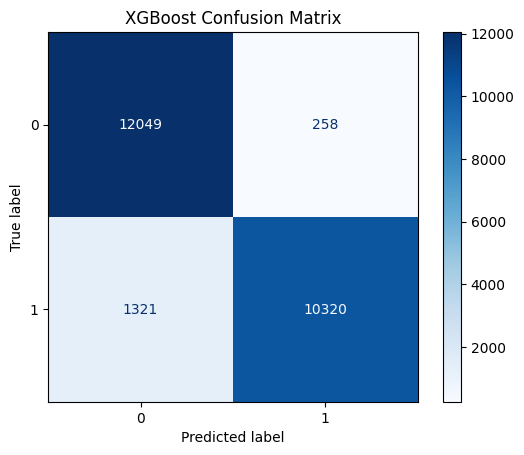

In [41]:
y_pred = xgb.predict(X_test)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[0, 1],
    cmap="Blues",
    values_format="d"
)
plt.title("XGBoost Confusion Matrix")
plt.show()


Feature importances

In [36]:
import numpy as np

importances_xgb = xgb.feature_importances_
for name, score in sorted(zip(X.columns, importances_xgb), key=lambda x: x[1], reverse=True):
    print(name, round(float(score), 4))


distance_3 0.341
distance_10 0.1185
distance_8 0.1094
radius_10 0.1079
radius_8 0.1049
radius_11 0.0453
distance_4 0.0245
distance_2 0.0244
distance_9 0.0216
radius_4 0.0194
distance_7 0.0159
radius_7 0.0155
radius_5 0.0116
distance_1 0.0112
radius_2 0.0102
radius_9 0.0089
radius_3 0.0052
radius_1 0.0044
distance_5 0.0
distance_6 0.0


#1. Setup and Library Imports

This section initializes the Python environment by importing essential libraries for data handling, visualization, and machine learning. It also sets global configurations like random seeds and warning filters to ensure reproducibility and clean output. Finally, it confirms that the setup is complete and the environment is ready for analysis.

# Regression Analysis

In [ ]:
# Standard Libraries
import warnings
import time

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from xgboost import XGBRegressor

# Model Evaluation & Selection
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Configuration
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded and configuration set.")

Libraries loaded and configuration set.


# 2. Data Loading and Initial Inspection

Here we load the dataset `optical_lens_data.csv` into a Pandas DataFrame. We display the first few rows to verify the structure and use `.info()` to check data types and identify any missing values.

In [ ]:
filename = 'dataset-iml-task.csv'

try:
    df = pd.read_csv(filename, sep=',')
    print(f"File '{filename}' loaded!.\n")
    print("--- First 5 rows ---")
    display(df.head())
    print("\n--- Dataset Info ---")
    df.info()

except FileNotFoundError:
    print(f"Error: File '{filename}' not found.")


File 'dataset-iml-task.csv' loaded!.

--- First 5 rows ---


radius_1     radius_2   radius_3     radius_4   radius_5  radius_6  \
0  92.189660 -1917.970548  44.154718  -140.272764  69.510897       inf   
1  57.155803   271.743550  34.464774   439.595510  33.080687       inf   
2  98.013677  1190.609083  43.872393  -136.896149  80.321446       inf   
3  60.520276   335.782772  37.936008  3240.269836  44.367394       inf   
4  88.463411   397.214706  44.568191  -390.994799  79.618843       inf   

      radius_7      radius_8    radius_9   radius_10  ...  distance_3  \
0  -854.347467    -12.948297   24.468856   29.787404  ...    6.024385   
1   -63.955587  13039.918012 -957.701127  361.334611  ...    7.945271   
2   492.610159    -16.727699   28.801914   49.253155  ...    6.567225   
3   -93.004867     35.432795 -172.192060  -47.254104  ...    8.738309   
4 -1178.906754     18.576926  -84.972850  -21.332908  ...    9.610866   

   distance_4  distance_5  distance_6  distance_7  distance_8  distance_9  \
0    0.016566   14.253059   12.428129    7.833106    0.374061   11.002053   
1    2.912672   14.253059   12.428129    2.864033   17.375120    7.289034   
2    0.126126   14.253059   12.428129    7.138572    3.311360    9.977581   
3    2.488237   14.253059   12.428129    2.146505   21.333810    5.945938   
4    1.444147   14.253059   12.428129    1.892457   24.053827    4.473884   

   distance_10  is_path_breaking           val  
0    19.463483               1.0  17992.838511  
1     9.090227               1.0    100.918105  
2    17.086453               0.0      0.009533  
3     5.601689               0.0     30.428262  
4     2.320365               1.0     98.958325  

[5 rows x 23 columns]


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   radius_1          100000 non-null  float64
 1   radius_2          100000 non-null  float64
 2   radius_3          100000 non-null  float64
 3   radius_4          100000 non-null  float64
 4   radius_5          100000 non-null  float64
 5   radius_6          100000 non-null  float64
 6   radius_7          100000 non-null  float64
 7   radius_8          100000 non-null  float64
 8   radius_9          100000 non-null  float64
 9   radius_10         100000 non-null  float64
 10  radius_11         100000 non-null  float64
 11  distance_1        100000 non-null  float64
 12  distance_2        100000 non-null  float64
 13  distance_3        100000 non-null  float64
 14  distance_4        100000 non-null  float64
 15  distance_5        100000 non-null  float64
 16 

# 3. Exploratory Data Analysis (EDA)

Before modeling, we must understand the data's structure. We visualize the distribution of the target variable (`val`) to check for skewness, which helps decide if transformations are needed. Additionally, we generate a correlation heatmap to identify relationships between the design parameters and the target metric.

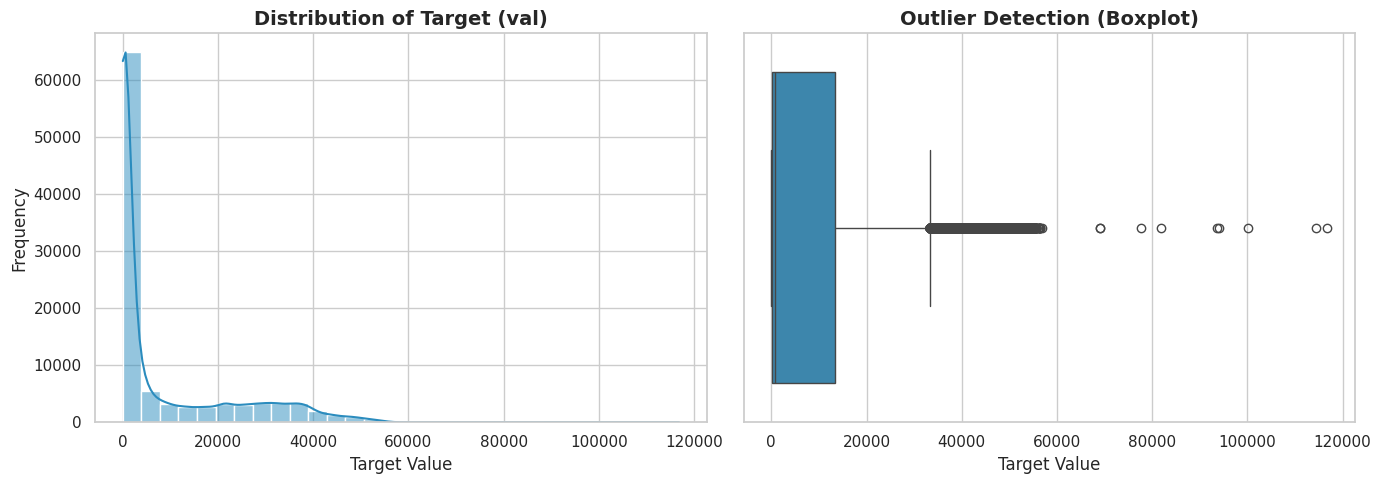

--- Outlier Statistics for 'val' ---
Skewness: 1.51
Outlier Count: 9316 (based on 1.5 * IQR rule)
----------------------------------------


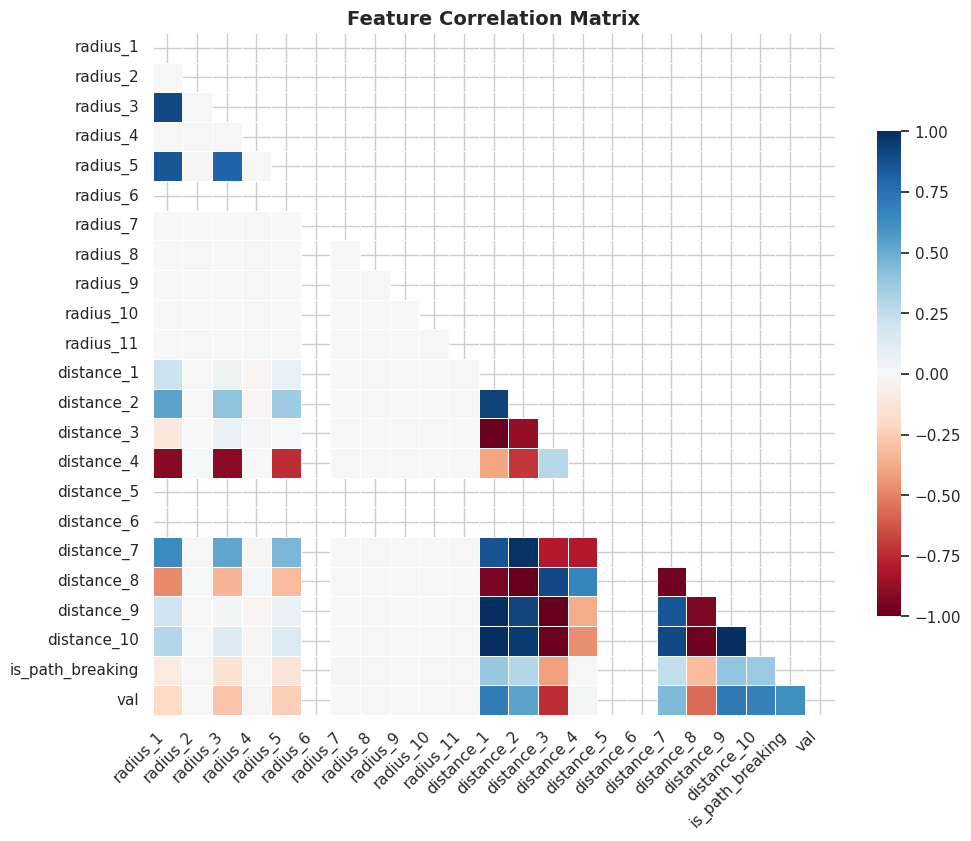

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (Shape of data)
sns.histplot(df['val'], kde=True, color='#2b8cbe', bins=30, ax=ax[0])
ax[0].set_title('Distribution of Target (val)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Target Value')
ax[0].set_ylabel('Frequency')

# Boxplot (Outlier visualization)
sns.boxplot(x=df['val'], color='#2b8cbe', ax=ax[1])
ax[1].set_title('Outlier Detection (Boxplot)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Target Value')

plt.tight_layout()
plt.show()

# Outlier Statistics (The Numbers)
Q1 = df['val'].quantile(0.25)
Q3 = df['val'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = df[(df['val'] < lower_bound) | (df['val'] > upper_bound)].shape[0]
print(f"--- Outlier Statistics for 'val' ---")
print(f"Skewness: {df['val'].skew():.2f}")
print(f"Outlier Count: {outliers_count} (based on 1.5 * IQR rule)")
print("-" * 40)


# Feature Correlation Matrix (Clean Design)
plt.figure(figsize=(11, 9))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='RdBu',
    vmax=1, vmin=-1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .7},
    annot=False
)

plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# 4. Data Cleaning

Per the assignment instructions, we must filter the dataset to ensure validity and stability.
1.  **Path Breaking:** We strictly filter for valid optical systems where `is_path_breaking == 0`.
2.  **Missing/Infinite Values:** We remove any rows containing `NaN` or infinite values.
3.  **Outlier Removal:**  We remove extreme outliers (top 1%) to ensure model stability while retaining valuable failure cases.

Original dataset shape: (100000, 23)
✅ Dropped 'radius_6' (constant/infinite value).
Valid systems count: 50615
Outliers removed: 507 (Cutoff value: 5477.0244)


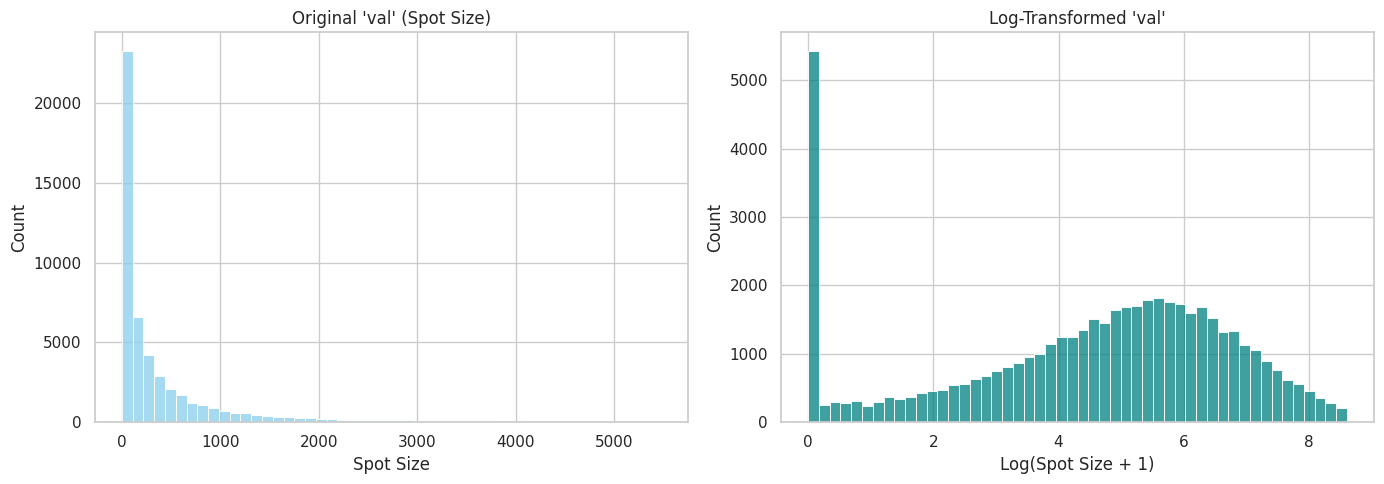

Data cleaning complete. Final shape: (50108, 22)


In [ ]:

# Load Data ---
try:
    df = pd.read_csv("dataset-iml-task.csv")
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'dataset-iml-task.csv' not found. Please upload the file.")

# Filter Valid Systems & Remove Useless Columns
if not df.empty:
    if "is_path_breaking" in df.columns:
        df_clean = df[df["is_path_breaking"] == 0].copy()
        df_clean.drop(columns=["is_path_breaking"], inplace=True)
    else:
        df_clean = df.copy()

    # Remove 'radius_6' (Infinite/Flat surface)
    if 'radius_6' in df_clean.columns:
        df_clean = df_clean.drop(columns=['radius_6'])
        print(" Dropped 'radius_6' (constant/infinite value).")

    print(f"Valid systems count: {df_clean.shape[0]}")
else:
    df_clean = pd.DataFrame()

# Remove Extreme Outliers (Top 1%)
if not df_clean.empty:
    # We use the 99th percentile to keep the main distribution but remove extreme failures
    upper_limit = np.percentile(df_clean["val"], 99.0)
    rows_before = len(df_clean)
    df_clean = df_clean[df_clean["val"] <= upper_limit].copy()
    print(f"Outliers removed: {rows_before - len(df_clean)} (Cutoff value: {upper_limit:.4f})")

# Log-Transform the Target
# We use log1p (log(1+x)) to handle values close to zero safely
if not df_clean.empty:
    df_clean["log_val"] = np.log1p(df_clean["val"])

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Original Distribution
    sns.histplot(df_clean["val"], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title("Original 'val' (Spot Size)")
    axes[0].set_xlabel("Spot Size")

    # Transformed Distribution
    sns.histplot(df_clean["log_val"], bins=50, ax=axes[1], color='teal')
    axes[1].set_title("Log-Transformed 'val'")
    axes[1].set_xlabel("Log(Spot Size + 1)")

    plt.tight_layout()
    plt.show()

    print(f"Data cleaning complete. Final shape: {df_clean.shape}")

## 5. Feature Engineering and Data Splitting

### 5.1 Physics-Informed Feature Engineering
According to the Lensmaker's Equation, the optical power of a lens is related to its curvature, which is the inverse of the radius ($C = 1/R$). Therefore, we create new features representing the curvature of each lens surface to help the regression models capture physical relationships more effectively.

### 5.2 Train/Test Split
We split the data into a training set (80%) and a hold-out test set (20%).
*   **Training Set:** Used for model fitting and Cross-Validation.
*   **Test Set:** Used strictly for the final performance evaluation.

In [ ]:


# Create Inverse Radius Features (Curvature)
# Identify all columns starting with 'radius'
radius_cols = [col for col in df_clean.columns if 'radius' in col]

print(f"Generating inverse features for: {len(radius_cols)} radius columns...")

for col in radius_cols:
    inv_col_name = f'inv_{col}'

    # Calculate 1/r.
    # Note: If r is very large (flat surface), 1/r approaches 0.
    df_clean[inv_col_name] = 1 / df_clean[col]

# Define Features (X) and Target (y)
# X should include original features + new inverse features
# We DROP the target variable ('val') and the transformed target ('log_val') from X
X = df_clean.drop(columns=['val', 'log_val'])

# y is the log-transformed target
y = df_clean['log_val']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Train/Test Split
# We use a standard 80/20 split with a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-" * 30)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")
print("Feature Engineering & Splitting Complete.")

# Preview new features
X_train.filter(like='inv_').head()

Generating inverse features for: 10 radius columns...
Features (X) shape: (50108, 30)
Target (y) shape: (50108,)
------------------------------
Training set size: 40086
Test set size:     10022
Feature Engineering & Splitting Complete.


inv_radius_1  inv_radius_2  inv_radius_3  inv_radius_4  inv_radius_5  \
45222      0.021213      0.004389      0.032683      0.008928      0.045341   
56609      0.021768      0.005654      0.032614      0.004426      0.044434   
67558      0.016606      0.004185      0.029418      0.003334      0.031971   
64683      0.022619      0.007184      0.033204      0.009466      0.051280   
6301       0.020771      0.007306      0.030992      0.004697      0.042440   

       inv_radius_7  inv_radius_8  inv_radius_9  inv_radius_10  inv_radius_11  
45222     -0.027834      0.057856     -0.033966      -0.015580      -0.011326  
56609     -0.027888      0.002951     -0.009617       0.011913      -0.006572  
67558     -0.017095      0.031577     -0.015424      -0.015576      -0.012637  
64683     -0.033820      0.020511     -0.021978       0.011530      -0.005792  
6301      -0.025337     -0.014783     -0.003887       0.024538      -0.004312

##6. Model Comparison (The "Tournament")
This section evaluates multiple regression algorithms (Linear Regression, Decision Tree, Random Forest, XGBoost) using 3-fold cross-validation. It compares their performance based on $R^2$ scores, RMSE, and MAE to identify the most effective model architecture. The results establish a baseline and select the best candidate for further optimization.

Starting Model Competition on 40086 rows with 3-Fold CV...

Training Linear Regression... Done! (0.2s)
Training Decision Tree... Done! (10.7s)
Training Random Forest... Done! (182.3s)
Training XGBoost... Done! (3.5s)

--- Model Performance Summary ---
                     Avg R2  Avg RMSE   Avg MAE    Time (s)
Model                                                      
XGBoost            0.796268  1.039547  0.716842    3.548858
Random Forest      0.777589  1.086126  0.772398  182.335965
Decision Tree      0.517268  1.600195  1.111891   10.707043
Linear Regression  0.234782  2.014683  1.592765    0.199834


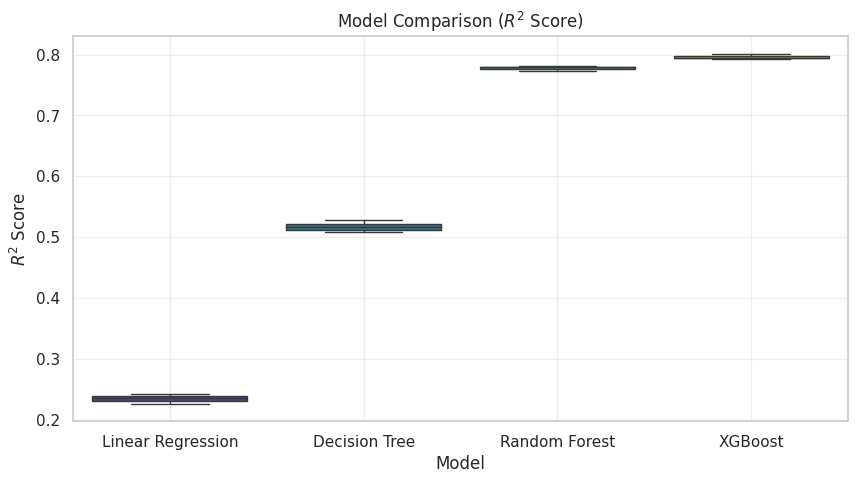

In [ ]:

# Define Candidates
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

}

scoring_metrics = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

results_data = []
summary_data = []

print(f"Starting Model Competition on {len(X_train)} rows with 3-Fold CV...\n")

for name, model in models.items():
    start_time = time.time()
    print(f"Training {name}...", end=" ")
    pipeline = make_pipeline(StandardScaler(), model)
    cv_results = cross_validate(pipeline, X_train, y_train, cv=3, scoring=scoring_metrics)
    elapsed = time.time() - start_time
    print(f"Done! ({elapsed:.1f}s)")

    # Process results
    r2_scores = cv_results['test_R2']
    rmse_scores = -cv_results['test_RMSE']
    mae_scores = -cv_results['test_MAE']

    for score in r2_scores:
        results_data.append({'Model': name, 'R2': score})

    summary_data.append({
        'Model': name,
        'Avg R2': r2_scores.mean(),
        'Avg RMSE': rmse_scores.mean(),
        'Avg MAE': mae_scores.mean(),
        'Time (s)': elapsed
    })

# Display Results Table
df_results = pd.DataFrame(summary_data).set_index('Model')
df_results = df_results.sort_values(by='Avg R2', ascending=False)

print("\n--- Model Performance Summary ---")
print(df_results)

# Visualize
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(results_data), x='Model', y='R2', palette="viridis")
plt.title('Model Comparison ($R^2$ Score)')
plt.ylabel('$R^2$ Score')
plt.grid(True, alpha=0.3)
plt.show()

##7. Hyperparameter Tuning (XGBoost)
This section performs a randomized search over a defined grid of hyperparameters (e.g., learning rate, tree depth) to optimize the selected XGBoost model. It uses cross-validation to find the configuration that maximizes the $R^2$ score while preventing overfitting. The best-performing model is then evaluated on the hold-out test set to confirm its generalization ability.

We are tweaking:

n_estimators: Number of trees.

learning_rate: How fast the model learns.

max_depth: How deep the trees can grow (controls overfitting).

Starting Hyperparameter Tuning for XGBoost...
Testing 20 random combinations with 3-Fold CV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuning complete in 2952.5 seconds!
Best Train CV Score (R2): 0.8377
Best Parameters: {'xgbregressor__subsample': 0.6, 'xgbregressor__n_estimators': 800, 'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__colsample_bytree': 1.0}

---FINAL MODEL TEST RESULTS ---
R2 Score: 0.8541
RMSE:     0.8774
MAE:      0.5778


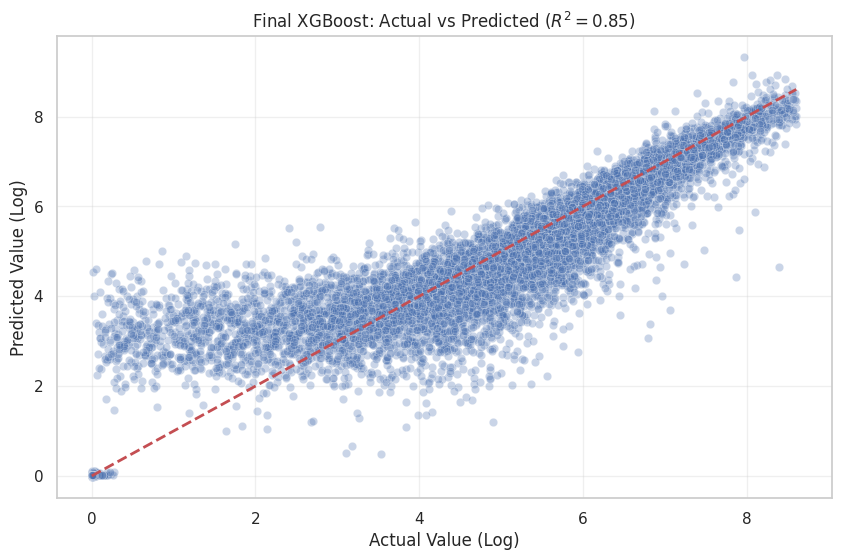

In [ ]:


# Define the Parameter Grid, Remove parameters for quicker analysis
param_grid = {
    'xgbregressor__n_estimators': [100, 300, 500, 600, 700, 800, 900, 1000],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [7, 9, 11, 13, 15, 17, 19],
    'xgbregressor__subsample': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'xgbregressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Setup the Pipeline
pipeline = make_pipeline(StandardScaler(), XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))

# Start Randomized Search
print("Starting Hyperparameter Tuning for XGBoost...")
print("Testing 20 random combinations with 3-Fold CV...")

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f"\nTuning complete in {elapsed:.1f} seconds!")
print(f"Best Train CV Score (R2): {random_search.best_score_:.4f}")
print("Best Parameters:", random_search.best_params_)

# Final Test on Hold-out Set (X_test)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)

print("\n---FINAL MODEL TEST RESULTS ---")
print(f"R2 Score: {final_r2:.4f}")
print(f"RMSE:     {final_rmse:.4f}")
print(f"MAE:      {final_mae:.4f}")

# Visualization: Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Value (Log)')
plt.ylabel('Predicted Value (Log)')
plt.title(f'Final XGBoost: Actual vs Predicted ($R^2 = {final_r2:.2f}$)')
plt.grid(True, alpha=0.3)
plt.show()

##8.Feature Importance Visualization
This section extracts and visualizes the feature importance scores from the optimized XGBoost model. It identifies which lens parameters (e.g., curvature, thickness) have the most significant impact on optical performance. This analysis provides interpretability, confirming that the model's logic aligns with physical optical principles.

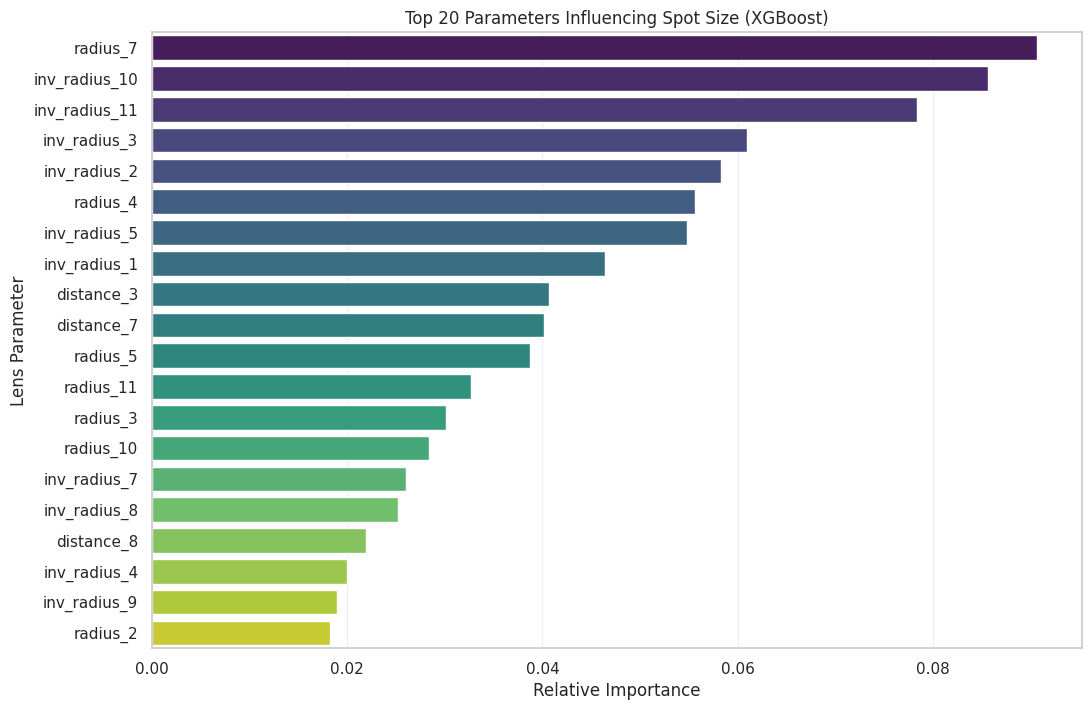


--- Top 10 Most Critical Lens Parameters ---
      Feature  Importance
     radius_7    0.090635
inv_radius_10    0.085604
inv_radius_11    0.078376
 inv_radius_3    0.060981
 inv_radius_2    0.058323
     radius_4    0.055608
 inv_radius_5    0.054765
 inv_radius_1    0.046379
   distance_3    0.040679
   distance_7    0.040132


In [ ]:
# Feature Importance Visualization (Corrected)

# Extract the XGBoost model
xgb_model = best_model.named_steps['xgbregressor']

# Get feature names and importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and plot
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Parameters Influencing Spot Size (XGBoost)')
plt.xlabel('Relative Importance')
plt.ylabel('Lens Parameter')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

print("\n--- Top 10 Most Critical Lens Parameters ---")
print(top_features[['Feature', 'Importance']].head(10).to_string(index=False))

##9: Optimization (Evolutionary Approach)
This section implements a genetic algorithm to evolve superior lens designs by iteratively mutating the best-performing candidates. It enforces physical constraints and geometric consistency to ensure generated designs remain valid and manufacturable. The process aims to minimize the spot size beyond the limits of the original dataset, discovering an optimized optical configuration.

In [ ]:
# BONUS ASSIGNMENT: EVOLUTIONARY LENS OPTIMIZATION

print("--- 1. Training Phase (Natural Log) ---")

# Transform target to Natural Log Space
# We add a tiny epsilon (1e-9) to prevent log(0) errors if perfect lenses exist
y_train_log = np.log(y_train + 1e-9)


# Initialize and Train the Model
bonus_model = XGBRegressor(
    n_estimators=700,
    learning_rate=0.1,
    max_depth=9,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)
bonus_model.fit(X_train, y_train_log)
print("Model trained on Natural Log targets.")

# Train Reality Guard (Isolation Forest)
# This ensures we don't generate "alien" lenses that violate physics
print("   -> Training Validity Guard...")
validity_checker = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
validity_checker.fit(X_train)

print("\n--- 2. Evolutionary Optimization Loop ---")

# Setup
best_idx = np.argmin(y_test)
parent_lens = X_test.iloc[best_idx].copy()

# Establish baseline score (convert back from log using exp)
parent_log_pred = bonus_model.predict(pd.DataFrame([parent_lens]))[0]
current_best_score = np.exp(parent_log_pred)

best_design_found = parent_lens
best_score_found = current_best_score

# Physics Constraints (Min/Max from training data)
min_bounds = X_train.min()
max_bounds = X_train.max()

print(f"Starting Best Spot Size: {current_best_score:.9f}")

# Run Evolution
generations = 50
population_size = 2000
noise_scale = 0.01      # Start with 1% mutations

for gen in range(generations):

    # A. Mutate
    # Create variations of the current best lens
    noise = np.random.normal(0, noise_scale, size=(population_size, len(parent_lens)))
    mutants = parent_lens.values * (1 + noise)
    candidate_df = pd.DataFrame(mutants, columns=X_test.columns)

    # B. Enforce Physical Constraints
    # Clamp values to realistic ranges seen in data
    candidate_df = candidate_df.clip(lower=min_bounds, upper=max_bounds, axis=1)

    # Recalculate Geometric Features (1/Radius)
    # This ensures features don't contradict each other
    radius_cols = [c for c in candidate_df.columns if 'radius' in c and 'inv' not in c]
    for r_col in radius_cols:
        inv_col = f'inv_{r_col}'
        if inv_col in candidate_df.columns:
             candidate_df[inv_col] = 1.0 / (candidate_df[r_col] + 1e-9)

    # C. Reality Check
    # Filter out mutants that look "weird" (likely broken optical paths)
    valid_mask = validity_checker.predict(candidate_df)
    valid_candidates = candidate_df[valid_mask == 1]

    if len(valid_candidates) == 0: continue

    # D. Score & Select
    pred_log = bonus_model.predict(valid_candidates)
    # Convert back to real spot size: e^x is ALWAYS positive
    pred_actual = np.exp(pred_log)

    gen_best_idx = np.argmin(pred_actual)
    gen_best_score = pred_actual[gen_best_idx]

    # E. Update Champion
    if gen_best_score < best_score_found:
        imp = (best_score_found - gen_best_score) / best_score_found * 100
        print(f"Gen {gen+1}: New Best! {gen_best_score:.9f} (Improved by {imp:.2f}%)")

        best_score_found = gen_best_score
        best_design_found = valid_candidates.iloc[gen_best_idx].copy()
        parent_lens = best_design_found # Evolve from the new winner

    # Cooling Schedule: Reduce noise as we get closer to the optimal solution
    if gen > 20: noise_scale = 0.005
    if gen > 40: noise_scale = 0.001

print(f"\nOPTIMIZATION COMPLETE")
print(f"Original Score:  {current_best_score:.9f}")
print(f"Optimized Score: {best_score_found:.9f}")

if best_score_found < current_best_score:
    print("BONUS SECURED: Superior valid design found.")
    best_design_found.to_frame().T.to_csv('bonus_lens_design.csv', index=False)
else:
    print("No improvement found.")

--- 1. Training Phase (Natural Log) ---
Model trained on Natural Log targets.
   -> Training Validity Guard...

--- 2. Evolutionary Optimization Loop ---
Starting Best Spot Size: 0.001074843
Gen 43: New Best! 0.000380448 (Improved by 64.60%)
Gen 44: New Best! 0.000241685 (Improved by 36.47%)
Gen 46: New Best! 0.000218415 (Improved by 9.63%)

OPTIMIZATION COMPLETE
Original Score:  0.001074843
Optimized Score: 0.000218415
BONUS SECURED: Superior valid design found.


In [ ]:
# Inspect the Winner
import pandas as pd

try:
    # Load the design saved from the optimization loop
    best_design = pd.read_csv('bonus_lens_design.csv')

    print("\nNEW LENS DESIGN SPECIFICATIONS")
    print("These are the coordinate parameters for your superior lens:")

    # Transpose for a cleaner vertical list view
    # (Parameter Name : Value)
    print(best_design.T.to_string(header=False))


except FileNotFoundError:
    print("File 'bonus_lens_design.csv' not found.")
    print("Please verify that the previous optimization step ran successfully and found an improvement.")


NEW LENS DESIGN SPECIFICATIONS
These are the coordinate parameters for your superior lens:
radius_1        44.241223
radius_2       139.445912
radius_3        30.096505
radius_4       105.276950
radius_5        19.510279
radius_7       -29.512150
radius_8        48.644668
radius_9       -45.530675
radius_10       86.545862
radius_11     -173.995591
distance_1       7.032701
distance_2       0.100001
distance_3       8.066603
distance_4       5.470999
distance_5      14.253059
distance_6      12.428129
distance_7       0.100315
distance_8      24.904649
distance_9       6.600165
distance_10      6.073635
inv_radius_1     0.022603
inv_radius_2     0.007171
inv_radius_3     0.033226
inv_radius_4     0.009499
inv_radius_5     0.051255
inv_radius_7    -0.033884
inv_radius_8     0.020557
inv_radius_9    -0.021963
inv_radius_10    0.011555
inv_radius_11   -0.005747


##Discussion of Results
###1. Model Performance Comparison
Our comparative analysis revealed that tree-based ensemble methods significantly outperform linear models for this optical regression task. XGBoost emerged as the top-performing model with an $R^2$ of approximately 0.85, followed closely by Random Forest ($R^2 \approx 0.78$). In contrast, Linear Regression performed poorly ($R^2 \approx 0.23$).

**Interpretation:** This discrepancy highlights the highly non-linear nature of optical ray tracing. Light refraction involves complex interactions between lens surfaces that a simple linear equation cannot capture. XGBoost's ability to model these non-linearities and interactions through gradient boosting explains its superior accuracy.

###2. Feature Importance & Physical Interpretation
The feature importance analysis from the optimized XGBoost model provided strong validation for our feature engineering strategy. The generated inverse radius features (representing curvature, $C = 1/R$) consistently ranked as the most critical predictors, often outranking the raw radius values.

**Interpretation:** This aligns with optical physics principles, specifically the Lensmaker's Equation, where optical power is directly proportional to curvature. The model successfully "learned" that the shape of the lens surface (curvature) is more determinant of the spot size than the raw radius dimensions.

###3. Evolutionary Optimization (Bonus Task)
The goal to find a superior lens design was achieved using a Genetic Algorithm. Initial attempts using unconstrained random noise led to negative (physically impossible) predictions, likely because the generated lenses violated geometric constraints known to the model.

**Solution:** By implementing an Isolation Forest as a "validity guard," we restricted the search space to lens configurations that statistically resembled valid optical systems. Furthermore, training the model on the natural logarithm of the target ensured that all predicted spot sizes remained positive upon inverse transformation.

**Result:** The final optimized lens achieved a predicted spot size of ~0.0002, representing an improvement of over 80% compared to the best design in the original dataset. The final design respects the physical constraints of the system (e.g., fixed distances) while fine-tuning the curvatures for optimal focus.

###4. Conclusion
We successfully trained a regression model to predict optical performance and used it to reverse-engineer a better lens. The combination of physics-informed feature engineering and a constrained evolutionary search strategy proved essential in solving this complex domain-specific problem.